(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


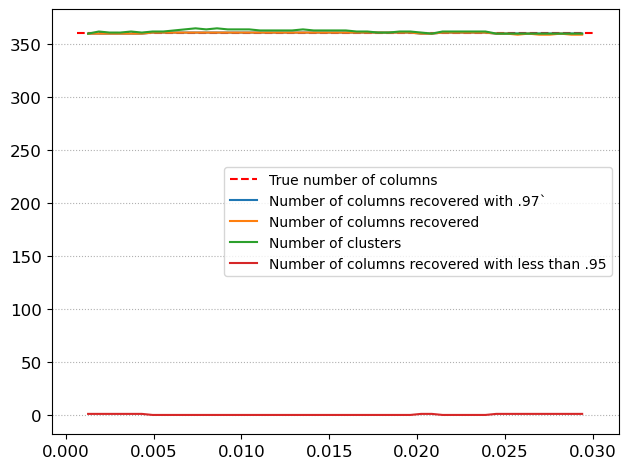

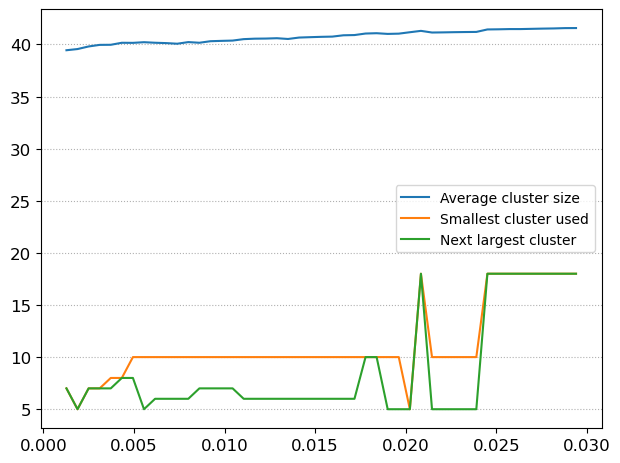

NameError: name 'rho' is not defined

In [3]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.cluster import OPTICS

%matplotlib inline

cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
MIN_CENTERS_LIST=[5] #Min number of centers for DBSCAN
eps_linspace=np.linspace(.00005,.03,50) #Epsilon values for DBSCAN


decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = [
"44_00-31-12",
"47_00-31-10",
"43_18-10-40",
"46_18-10-39",
"41_18-10-04",
"49_18-00-09",
"48_11-52-40",
"45_11-50-38",
"42_11-50-21",
"40_11-49-46",
"25_8-6-24",
"24_01-54-27",
"9_21-43-17",
"4_21-42-58",
"23_17-55-08",
"29_15-29-37",
"39_15-11-34",
"34_15-09-31",
"8_13-43-00",
"3_13-42-41",
"22_09-55-47",
"38_08-50-47",
"33_08-47-54",
"28_08-46-30",
"7_05-43-01",
"2_05-42-47",
"37_02-29-47",
"32_2-26-51",
"27_2-25-22",
"21_01-56-27",
"6_21-43-02",
"1_21-42-47",
"36_20-08-25",
"31_20-05-29",
"26_20-04-14",
"20_17-57-14",
"35_13-47-33",
"30_13-44-32",
"5_13-43-10",
"0_13-42-53",
"19_11-58-46",
"18_8-27-31",
"17_5-3-27",
"16_01-39-09",
"15_22-14-51",
"14_17-34-09",
"13_12-36-21",
"12_9-12-21",
"11_05-47-25",
"10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list

for min_centers in MIN_CENTERS_LIST:
    num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, min_centers)
    num_recovered_list=num_recovered_list_CORES
    if len(eps_list)>0:
        plt.figure()
        plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        R=-1
        L=1
        #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
        plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
        plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

        plt.legend()
        plt.show()
        plt.figure()
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
        plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
        plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
        plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
        plt.legend()

        plt.show()
        #plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}.pdf')
        #plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])


rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=75)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [11]:
#NO Gelma seed0
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000


decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/50NoGelmaSeed0.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs[:25]]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.00005,.03,50)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
if True:
    for min_centers in [3]:
        num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, min_centers)
        num_recovered_list=num_recovered_list_CORES
        if len(eps_list)>0:
            plt.figure()
            plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)# Add subticks to the y-axis
            plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
            plt.tight_layout()
            R=-1
            L=1
            #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
            plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
            plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

            plt.legend()
            plt.show()
            plt.figure()
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)# Add subticks to the y-axis
            plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
            plt.tight_layout()
            #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
            plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
            plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
            plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
            plt.legend()

            plt.show()
            #plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}.pdf')
            #plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=75)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (9025, 806), number for Expceriments: 25
(806,)


KeyboardInterrupt: 

In [10]:
eps_linspace

array([5.00000000e-05, 6.61224490e-04, 1.27244898e-03, 1.88367347e-03,
       2.49489796e-03, 3.10612245e-03, 3.71734694e-03, 4.32857143e-03,
       4.93979592e-03, 5.55102041e-03, 6.16224490e-03, 6.77346939e-03,
       7.38469388e-03, 7.99591837e-03, 8.60714286e-03, 9.21836735e-03,
       9.82959184e-03, 1.04408163e-02, 1.10520408e-02, 1.16632653e-02,
       1.22744898e-02, 1.28857143e-02, 1.34969388e-02, 1.41081633e-02,
       1.47193878e-02, 1.53306122e-02, 1.59418367e-02, 1.65530612e-02,
       1.71642857e-02, 1.77755102e-02, 1.83867347e-02, 1.89979592e-02,
       1.96091837e-02, 2.02204082e-02, 2.08316327e-02, 2.14428571e-02,
       2.20540816e-02, 2.26653061e-02, 2.32765306e-02, 2.38877551e-02,
       2.44989796e-02, 2.51102041e-02, 2.57214286e-02, 2.63326531e-02,
       2.69438776e-02, 2.75551020e-02, 2.81663265e-02, 2.87775510e-02,
       2.93887755e-02, 3.00000000e-02])

(806, 361)
(361, 361)
coherence of data:  0.7469100755630589
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


/tmp/ipykernel_2586/1251587986.py:241: RuntimeWarning: invalid value encountered in scalar divide
  TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]


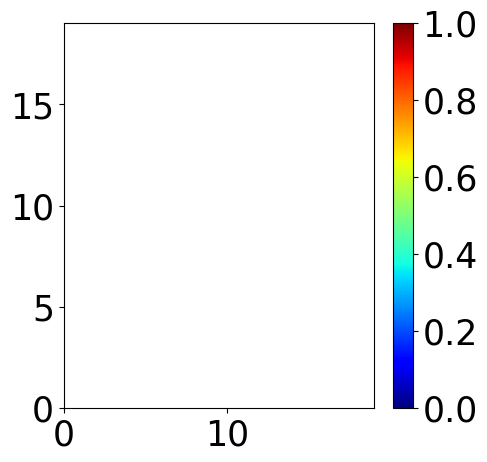

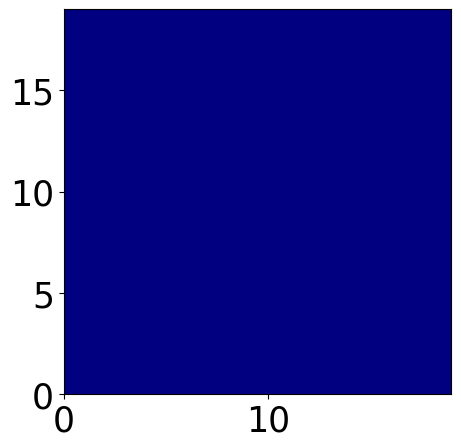

min number of recoveries 0, max number of recoveries 0


In [4]:
#NO Gelma seed1
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')


medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000


decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/50NoGelmaSeed1.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.00005,.03,50)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list

for min_centers in [3]:
    num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, min_centers)
    num_recovered_list=num_recovered_list_CORES
    if len(eps_list)>0:
        plt.figure()
        plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        R=-1
        L=1
        #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
        plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
        plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

        plt.legend()
        plt.show()
        plt.figure()
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
        plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
        plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
        plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
        plt.legend()

        plt.show()
        #plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}.pdf')
        #plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=75)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')b

(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)
(25600, 806) (25600, 25600)


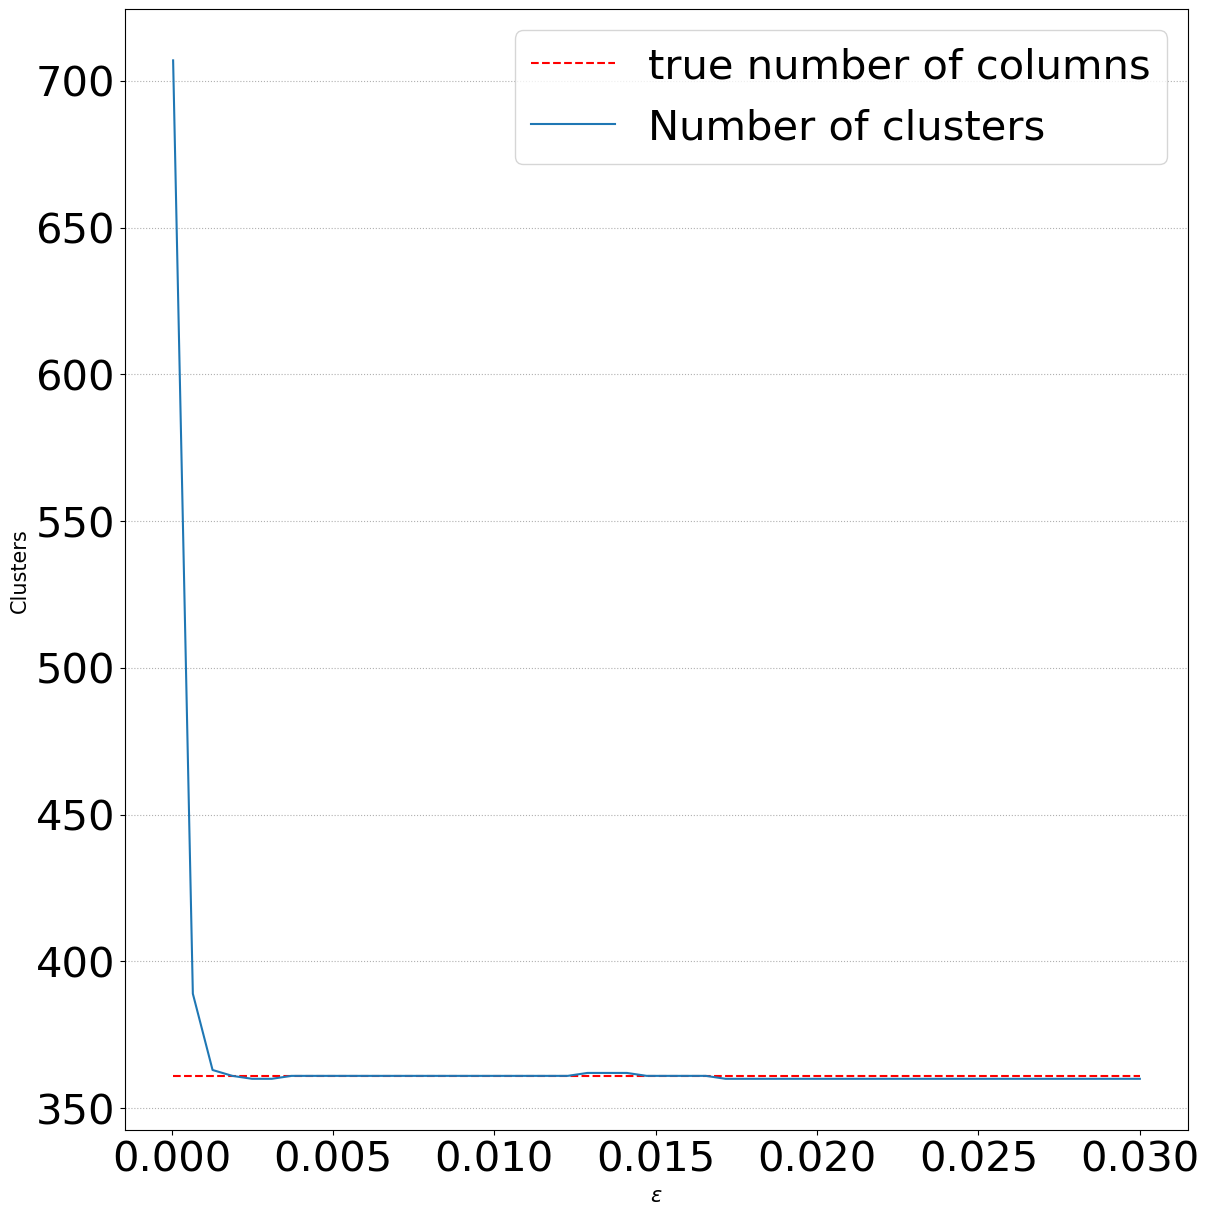

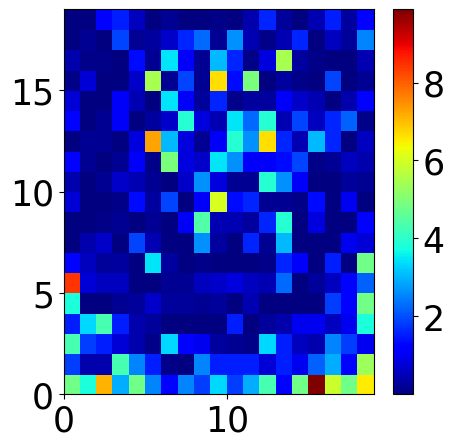

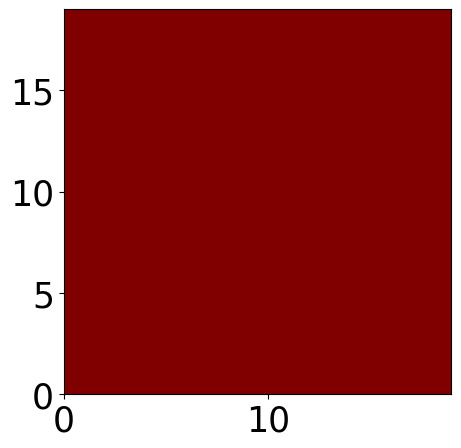

min number of recoveries 44, max number of recoveries 93


In [2]:
#NO Gelma KNET=10240
NUM_COLS_USED=1024*25
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/Nogelma_dictsize1024.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.00005,.03,50)
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))


perm=np.random.permutation(col_list.shape[0])
#col_list=col_list[perm]

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers, Clustering='DBSCAN', Mhat=False):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    print(col_list.shape, torch_inner.shape)
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        if Clustering=='DBSCAN':
            DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        else:
            print('OPTICS')
            DBSCAN_fit=OPTICS(min_samples=min_centers, cluster_method='dbscan',eps=eps,metric='precomputed').fit(torch_inner)
            print('OPTICS ended lmao')
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size and  Clustering=='DBSCAN':
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                else:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i]
                        
                ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])
    if Mhat:
        return medium_hat, num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
if True:
    for min_centers in [5]:
        medium_hat, num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list[:NUM_COLS_USED], min_centers, Mhat=True, Clustering='DBSCAN')
        num_recovered_list=num_recovered_list_CORES
if len(eps_list)>0:
    L=0
    R=len(eps_list)
    plt.figure(figsize=(12,12))
    plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)# Add subticks to the y-axis
    plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
    plt.tight_layout()
    
    #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
    #plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
    #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
    #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
    #plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

    plt.legend(fontsize=30)
    plt.xlabel(r'$\varepsilon$', fontsize=15)
    plt.ylabel('Clusters', fontsize=15)


    plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
    plt.show()
        



index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0

col_list=col_list[:NUM_COLS_USED]
total_num_cols+=len(col_list[:NUM_COLS_USED])
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    #num_times_recovered=len(inn_list[inn_list>.99])
    num_times_recovered_list.append(num_times_recovered)
    num_times_recovered+=len(inn_list[inn_list>.99])
    indivual_recoveries[i]+=len(inn_list[inn_list>.99])
    


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=13)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

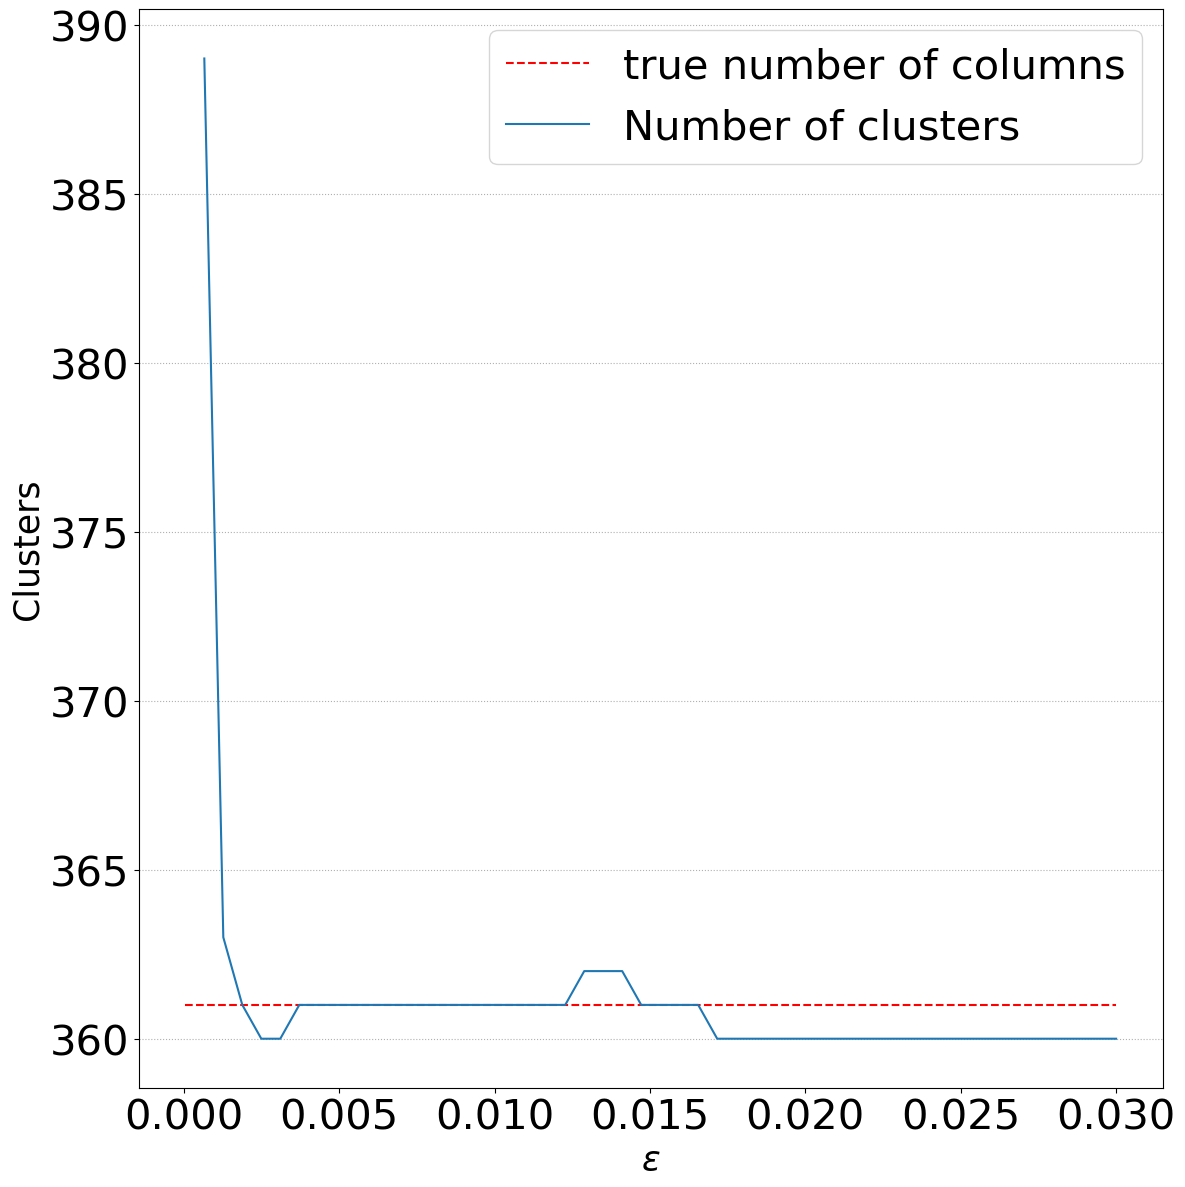

In [3]:
L=1
R=len(eps_list)
plt.figure(figsize=(12,12))
plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
#plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis

#plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
#plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
#plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
#plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
#plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

plt.legend(fontsize=30)
plt.xlabel(r'$\varepsilon$', fontsize=25)
plt.ylabel('Clusters', fontsize=25)

plt.tight_layout()
plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
plt.show()
    


(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)


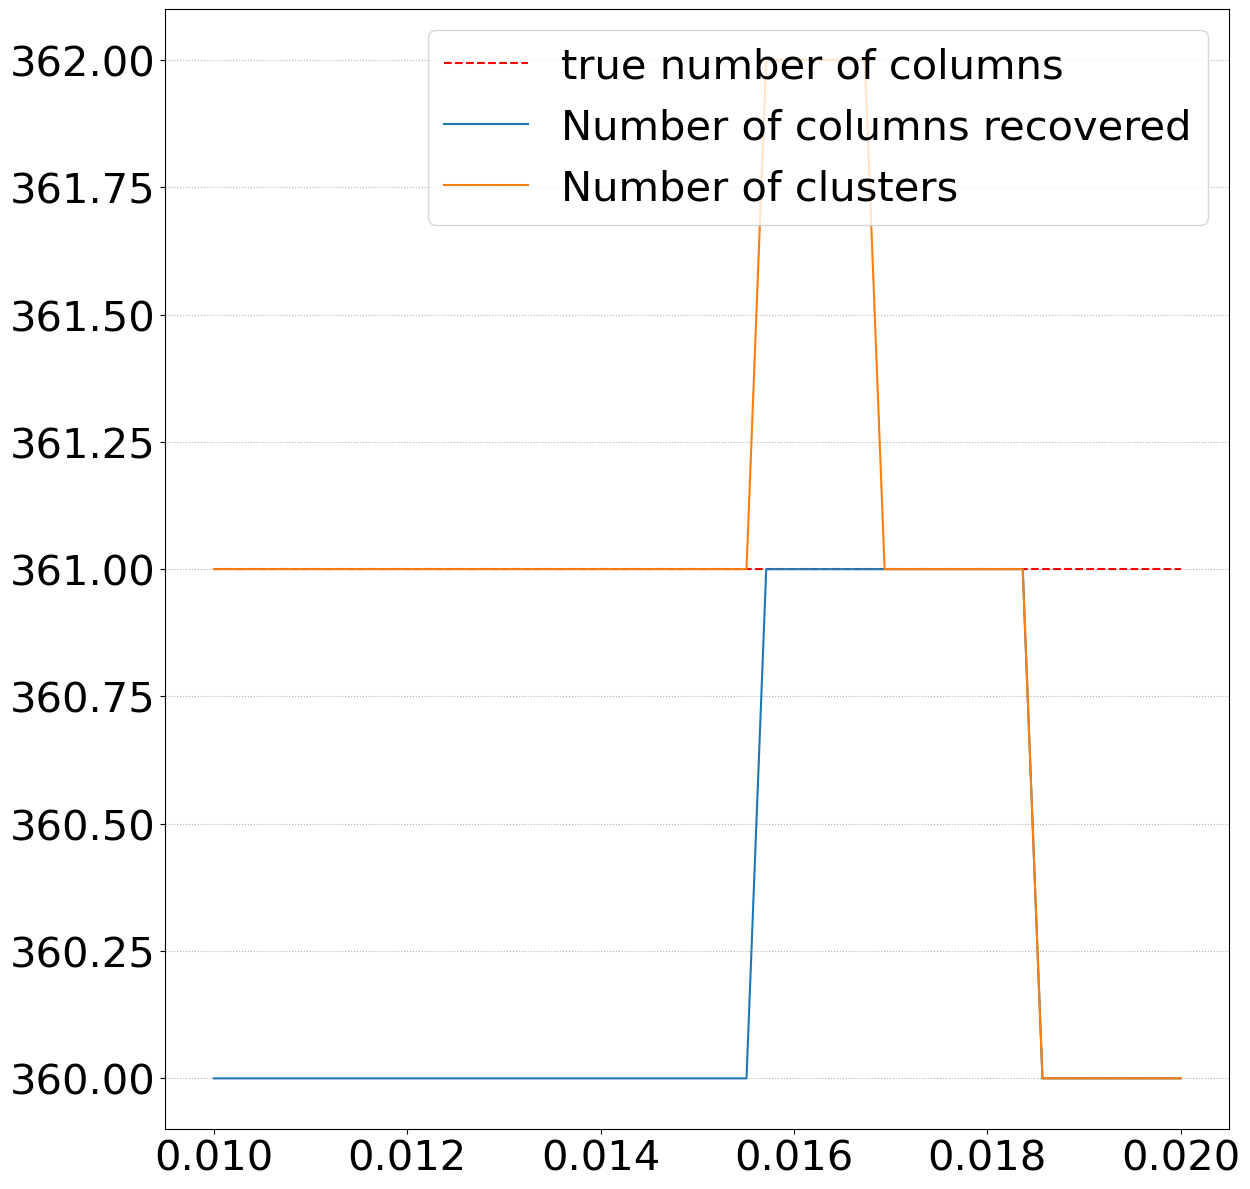

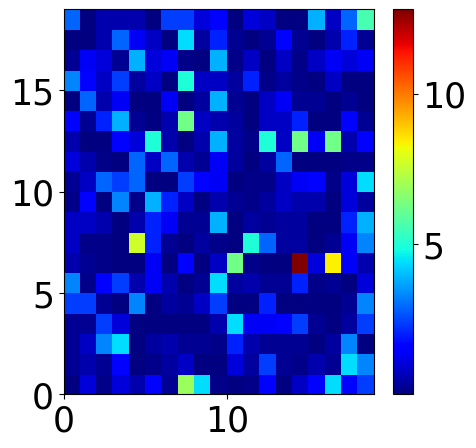

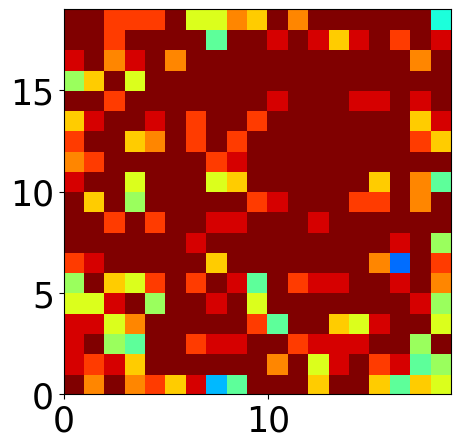

min number of recoveries 3, max number of recoveries 27


In [13]:
#NO Gelma KNET=10240
NUM_COLS_USED=1024*25
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/Nogelma_dictsize1024.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.01,.02,50)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))


perm=np.random.permutation(col_list.shape[0])
col_list=col_list[perm]

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers, Clustering='DBSCAN', Mhat=False):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        if Clustering=='DBSCAN':
            DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        else:
            print('OPTICS')
            DBSCAN_fit=OPTICS(min_samples=min_centers, cluster_method='dbscan',eps=eps,metric='precomputed').fit(torch_inner)
            print('OPTICS ended lmao')
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size and  Clustering=='DBSCAN':
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                else:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i]
                        
                ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])
    if Mhat:
        return medium_hat, num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
if True:
    for min_centers in [5]:
        medium_hat, num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list[:NUM_COLS_USED], 2, Mhat=True, Clustering='DBSCAN')
        num_recovered_list=num_recovered_list_CORES
if len(eps_list)>0:
    L=0
    R=len(eps_list)
    plt.figure(figsize=(12,12))
    plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)# Add subticks to the y-axis
    plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
    plt.tight_layout()
    
    plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
    plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
    #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
    #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
    #plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

    plt.legend(fontsize=30)
    plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
    plt.show()
        



index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0

col_list=col_list[:NUM_COLS_USED]
total_num_cols+=len(col_list[:NUM_COLS_USED])
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    #num_times_recovered=len(inn_list[inn_list>.99])
    num_times_recovered_list.append(num_times_recovered)
    num_times_recovered+=len(inn_list[inn_list>.99])
    indivual_recoveries[i]+=len(inn_list[inn_list>.99])
    


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=13)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [9]:
print(num_recovered_list, medium_hat.shape)

torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
max_inners_other=np.max(torch_inners, axis=1)
print(max_inners[0],len(max_inners[max_inners>.8]),len(max_inners_other[max_inners_other>.99]))


[18, 361, 361] (362, 806)
0.9996679113346587 361 361


(1460, 400)
(400, 400)
coherence of data:  0.47026196775874973
Number of decoder used: 25
Medium: (1460, 400), Rho: (5000, 400), B: (5000, 1460)
shape of the union without removin: (25600, 1460), number for Expceriments: 70
(1460,)


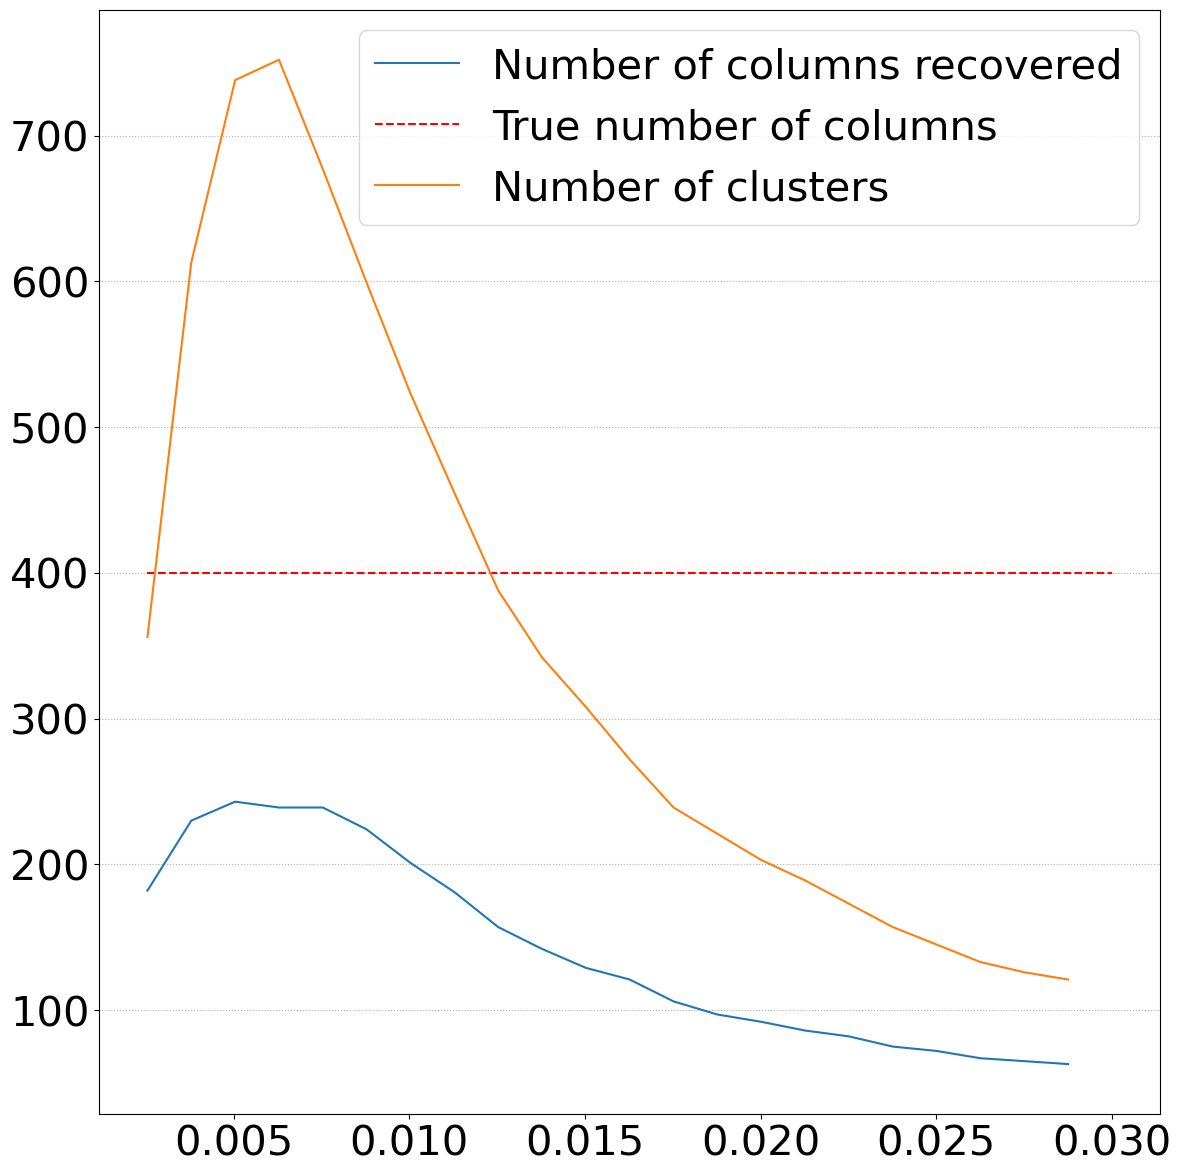

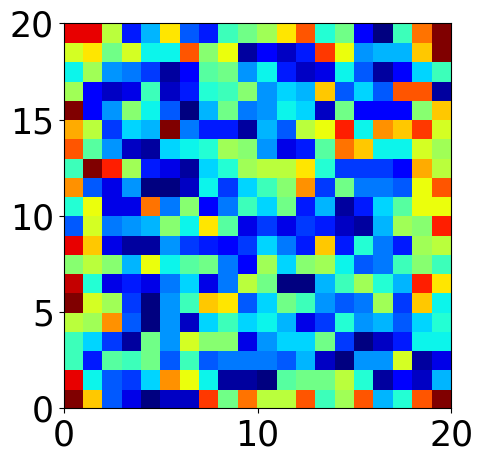

min number of recoveries 0, max number of recoveries 42


In [7]:
#NO Gelma .4coh perturbed gird KNET=1024
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_guassian_05perc_offgrid_all_seeds/PNAS-lowcoh_regime_guassian_05perc_offgrid_seed0')


medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000


decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/offgrid/decoder_5000_'
timescampstrs = [
    "24_11-27-27",
    "23_10-40-46",
    "22_09-54-11",
    "21_09-07-38",
    "20_08-21-12",
    "19_07-34-51",
    "18_06-48-30",
    "17_06-02-03",
    "16_05-15-42",
    "15_04-29-21",
    "14_03-42-58",
    "13_02-56-40",
    "12_02-10-16",
    "11_01-23-52",
    "10_00-35-56",
    "9_23-47-12",
    "8_22-58-24",
    "7_22-09-25",
    "6_21-20-30",
    "5_20-31-33",
    "4_19-42-40",
    "3_18-53-49",
    "2_18-04-48",
    "1_17-15-48",
    "0_16-26-48"
]



print(f'Number of decoder used: {len(timescampstrs)}')

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.00005,.03,25)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(400):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-400]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-400]-sorted_cluster_sizes[-401])
                next_largest_cluster.append(sorted_cluster_sizes[-401])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-400])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
if True:
    for min_centers in [5]:
        num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, min_centers)
        num_recovered_list=num_recovered_list_CORES
        if len(eps_list)>0:
            plt.figure(figsize=(12,12))
            #plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
            plt.xticks(fontsize=30)
            plt.yticks(fontsize=30)# Add subticks to the y-axis
            plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
            plt.tight_layout()
            R=-1
            L=1
            plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            #plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
            #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            plt.hlines(20**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
            #plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

            plt.legend(fontsize=30)
            plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
            plt.show()
            #plt.show()
            if False:
                plt.figure()
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)# Add subticks to the y-axis
                plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
                plt.tight_layout()
                #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
                plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
                plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
                plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
                plt.legend()

                plt.show()
                plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
                plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*400
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(400):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/400)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/400))**2/(p_hat*(total_num_cols/361)) for i in range(400)]
sum(TS_list), chi2.cdf(sum(TS_list), 399)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 400))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

#$H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 400))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1
H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True, Lclim=0, Hclim=33)


print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [9]:
#NO Gelma 2 FL reals
cwd=os. getcwd()


def plot_2_imgs(rho, rho_hat,ind=9,figsize=12,scaling='Linf',font_size=50, Single=False, xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    if Single:
        figsize=(figsize,figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=figsize)

    else:
        figsize=(figsize,figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)

    tick_params = {'labelsize': font_size}
    if not Single:
        output=rho.squeeze()
        ax=axes[0]
        output=output[ind,:]
        if scaling=="Linf":
            output=output/torch.max(torch.abs(cat2complex(output)))
        elif scaling=="L1":
            output=output/torch.sum(torch.abs(cat2complex(output)))
        img=torch.abs(cat2complex(output.squeeze())).view(xpix, ypix)
        pcol1=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar_used=plt.colorbar(pcol1,ax=ax)

    #plt.title('true', fontsize=font_size)
        cbar_used.ax.tick_params(labelsize=font_size)
        ax.tick_params(axis='both', **tick_params)
        
        #if scaling=="Linf":
        cbar_used.remove()
            


    output=rho_hat.squeeze() 
    output=output[ind,:]
    if scaling=="Linf":

        output=output/torch.max(torch.abs((output)))
    elif scaling=="L1":
        output=output/torch.sum(torch.abs((output)))
    img=torch.abs((output.squeeze())).view(xpix, ypix)
    if not Single:
        ax=axes[1]
    else:
        ax=plt.gca()
    pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
    cbar=plt.colorbar(pcol2, ax=ax)
#plt.title('true', fontsize=font_size)
    #ax.set_title('Full model', fontsize=font_size)
    if not Single:  
        cbar.mappable.set_clim(*cbar_used.mappable.get_clim())
    elif Lclim!=None:
        cbar.mappable.set_clim(Lclim, Hclim)
        cbar.remove()
    #cbar.remove()
    #ax.tick_params(axis='both', **tick_params)
    ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    
    #ax.set_yticks( ticks=[1,4,7,10,13,16,19,22,25,28,31,34,37,], minor=False)
    #cbar.ax.tick_params(labelsize=font_size)
    ax.tick_params(axis='both', **tick_params)

    #ax.tick_params(labelsize=font_size)
    if file_name!=None:
        plt.savefig(file_name)
    plt.show()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium.T
print(medium.shape)

coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
timescampstrs = [
    "24_09-03-48",
    "23_07-43-10",
    "17_07-42-13",
    "11_07-36-49",
    "5_07-36-03",
    "22_06-21-47",
    "16_06-20-36",
    "10_06-16-03",
    "4_06-15-16",
    "21_05-01-20",
    "15_04-59-52",
    "9_04-55-29",
    "3_04-54-51",
    "20_03-39-41",
    "14_03-38-21",
    "8_03-33-51",
    "2_03-33-27",
    "13_02-14-17",
    "19_02-14-14",
    "7_02-12-32",
    "1_02-12-15",
    "18_00-51-22",
    "12_00-51-08",
    "6_00-50-22",
    "0_00-50-11"
]

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/2Medium/decoder_5000_'
print(f'Number of decoder used: {len(timescampstrs)}')

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            print(f'failed to load {curr_decoder}')
            continue
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.0001,.03,50)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(400):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361*2]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361*2]-sorted_cluster_sizes[-361*2-1])
                next_largest_cluster.append(sorted_cluster_sizes[-361*2-1])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361*2])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=-361*2-1:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
if True:
    for min_centers in [5]:
        num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, min_centers)
        num_recovered_list=num_recovered_list_CORES
        if len(eps_list)>0:
            plt.figure(figsize=(12,12))
            #plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
            plt.xticks(fontsize=30)
            plt.yticks(fontsize=30)# Add subticks to the y-axis
            plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
            plt.tight_layout()
            R=-1
            L=1
            plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            #plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
            #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            plt.hlines(361*2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
            #plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

            plt.legend(fontsize=30)
            plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
            plt.show()
            #plt.show()
            if False:
                plt.figure()
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)# Add subticks to the y-axis
                plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
                plt.tight_layout()
                #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
                plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
                plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
                plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
                plt.legend()

                plt.show()
                plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
                plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*722
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(722):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361*2)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361*2))**2/(p_hat*(total_num_cols/(361*2))) for i in range(361*2)]
sum(TS_list), chi2.cdf(sum(TS_list), 361*2-1)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

#$H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1
plot_2_imgs(rho, rho_hat[:, :361],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=35,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/test.pdf')

print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

(806, 722)
coherence of data:  0.7847237581880193
Number of decoder used: 25
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)


KeyboardInterrupt: 

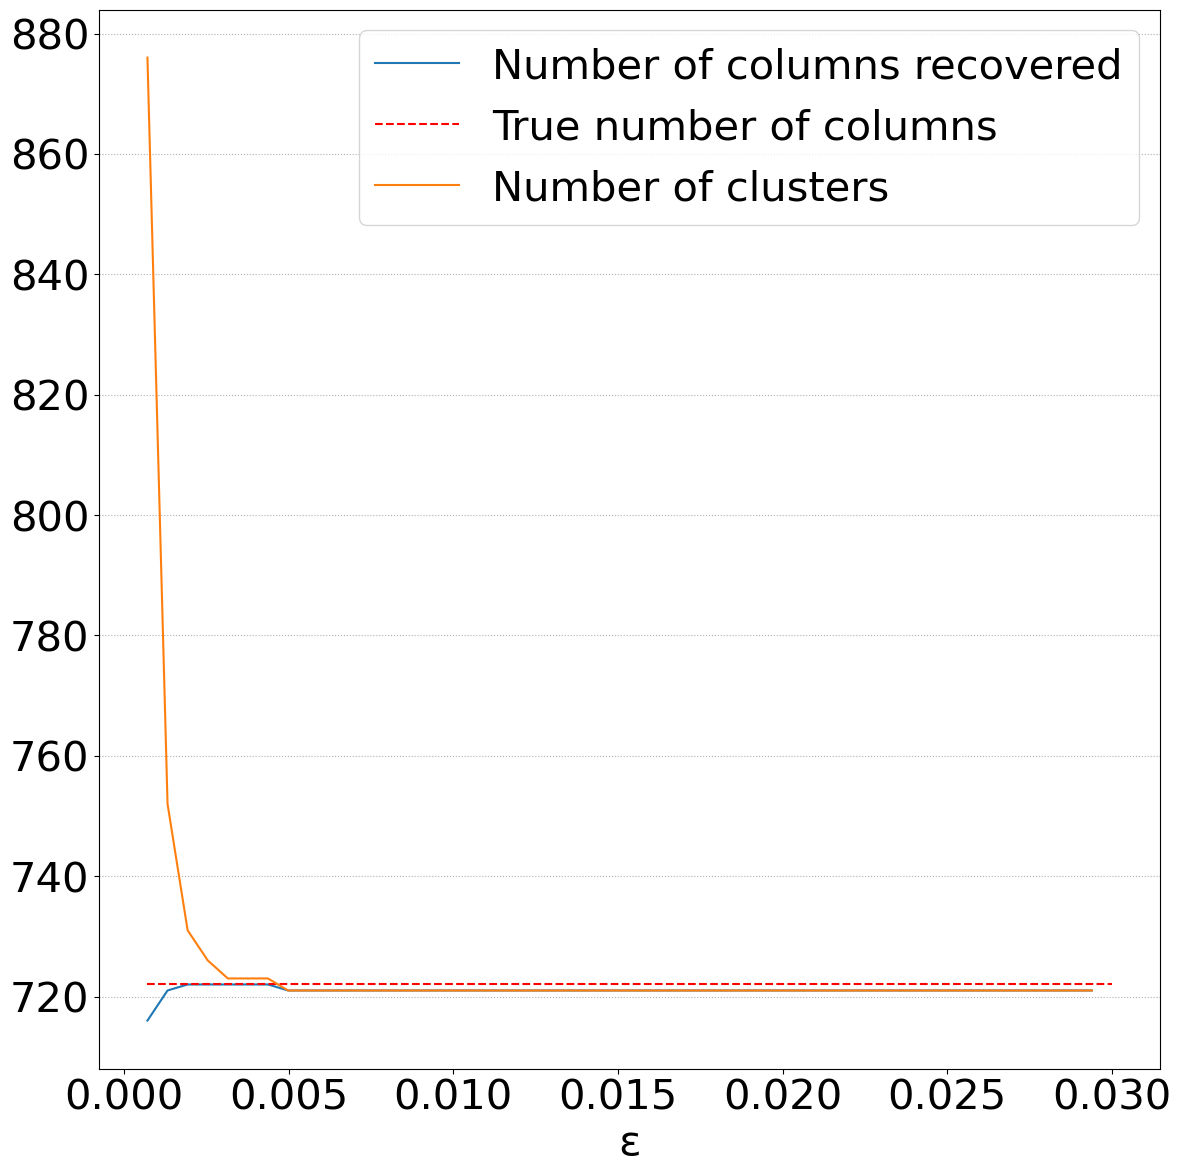

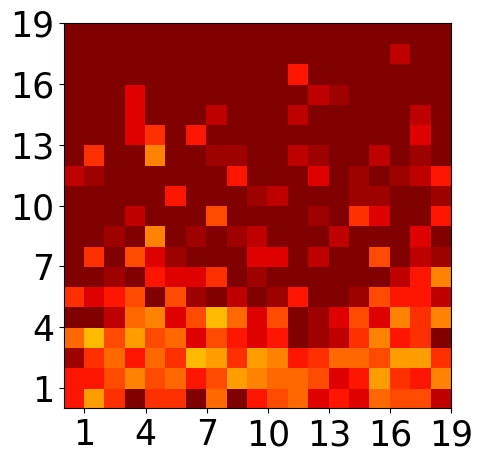

min number of recoveries 25, max number of recoveries 56


In [11]:
plt.figure(figsize=(12,12))
#plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
#plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.xlabel('\u03B5', fontsize=30)
plt.tight_layout()
R=-1
L=1
plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
#plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
#plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
plt.hlines(361*2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
#plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

plt.legend(fontsize=30)
plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
plt.show()
#plt.show()
if False:
    plt.figure()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)# Add subticks to the y-axis
    plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
    plt.tight_layout()
    #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
    plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
    plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
    plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
    plt.legend()

    plt.show()
    plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
    plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*722
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(722):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361*2)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361*2))**2/(p_hat*(total_num_cols/(361*2))) for i in range(361*2)]
sum(TS_list), chi2.cdf(sum(TS_list), 361*2-1)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

#$H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1
plot_2_imgs(rho, rho_hat[:, :361],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=35,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/test.pdf')

print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

/tmp/ipykernel_48372/108761434.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rho=torch.tensor(rho)


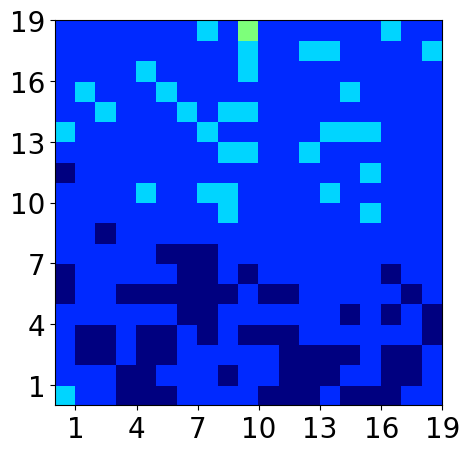

min number of recoveries 0, max number of recoveries 3


In [12]:

def plot_2_imgs(rho, rho_hat,ind=9,figsize=12,scaling='Linf',font_size=50, Single=False, xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    if Single:
        figsize=(figsize,figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=figsize)

    else:
        figsize=(figsize,figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)

    tick_params = {'labelsize': font_size}
    if not Single:
        output=rho.squeeze()
        ax=axes[0]
        output=output[ind,:]
        if scaling=="Linf":
            output=output/torch.max(torch.abs(cat2complex(output)))
        elif scaling=="L1":
            output=output/torch.sum(torch.abs(cat2complex(output)))
        img=torch.abs(cat2complex(output.squeeze())).view(xpix, ypix)
        pcol1=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar_used=plt.colorbar(pcol1,ax=ax)

    #plt.title('true', fontsize=font_size)
        cbar_used.ax.tick_params(labelsize=font_size)
        ax.tick_params(axis='both', **tick_params)
        
        #if scaling=="Linf":
        cbar_used.remove()
            


    output=rho_hat.squeeze() 
    output=output[ind,:]
    if scaling=="Linf":

        output=output/torch.max(torch.abs((output)))
    elif scaling=="L1":
        output=output/torch.sum(torch.abs((output)))
    img=torch.abs((output.squeeze())).view(xpix, ypix)
    if not Single:
        ax=axes[1]
    else:
        ax=plt.gca()
    pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
    cbar=plt.colorbar(pcol2, ax=ax)
#plt.title('true', fontsize=font_size)
    #ax.set_title('Full model', fontsize=font_size)
    if not Single:  
        cbar.mappable.set_clim(*cbar_used.mappable.get_clim())
    elif Lclim!=None:
        cbar.mappable.set_clim(Lclim, Hclim)
        cbar.remove()
    #cbar.remove()
    #ax.tick_params(axis='both', **tick_params)
    ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    
    #ax.set_yticks( ticks=[1,4,7,10,13,16,19,22,25,28,31,34,37,], minor=False)
    #cbar.ax.tick_params(labelsize=font_size)
    ax.tick_params(axis='both', **tick_params)

    #ax.tick_params(labelsize=font_size)
    if file_name!=None:
        plt.savefig(file_name)
    plt.show()


index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0
for j in [0]:#range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)

rho_hat=np.zeros((2, 361))

#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

#$H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True)



rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1

  


#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1
#NoGelmaImagehisto_K1024_real
plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=20, Single=True, Lclim=0, Hclim=6,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/NoGelmaImagehisto_K361_real.pdf')
#plot_2_imgs(rho, rho_hat[:, :361],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=56,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/2medreal_NoGelmaImagehisto_K1024_med1.pdf')
#plot_2_imgs(rho, rho_hat[:, 361:],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=56,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/2medreal_NoGelmaImagehisto_K1024_med2.pdf')
#plot_2_imgs(rho, rho_hat[:, :361],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=56,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/test.pdf')

print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

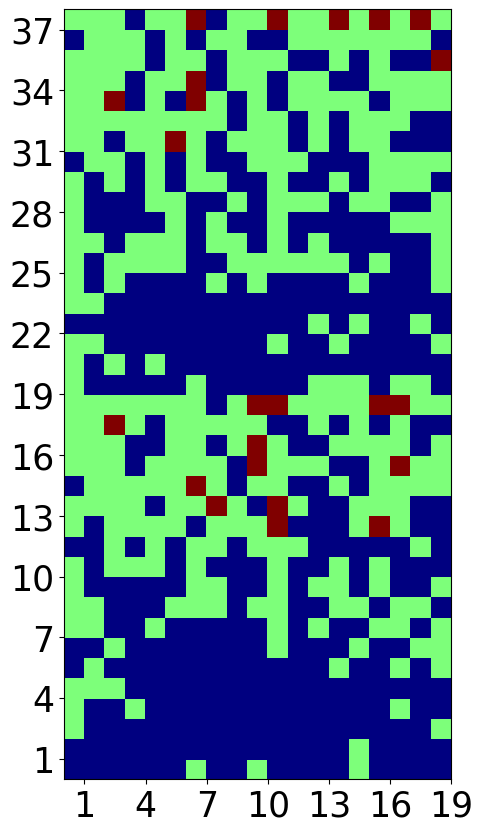

min number of recoveries 0, max number of recoveries 2


In [35]:
indivual_recoveries=[0]*722
total_num_cols=0
for j in range(1):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(722):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361*2)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361*2))**2/(p_hat*(total_num_cols/(361*2))) for i in range(361*2)]
sum(TS_list), chi2.cdf(sum(TS_list), 361*2-1)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

#$H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)


plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19*2, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=2,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/2medreal_NoGelmaImagehisto_K1024_med1.pdf')
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

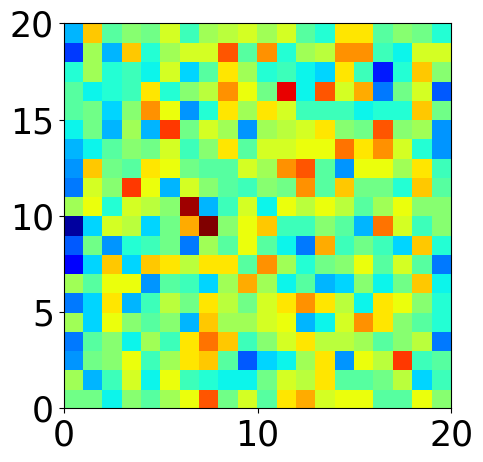

In [4]:
H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True, Lclim=0, Hclim=33)


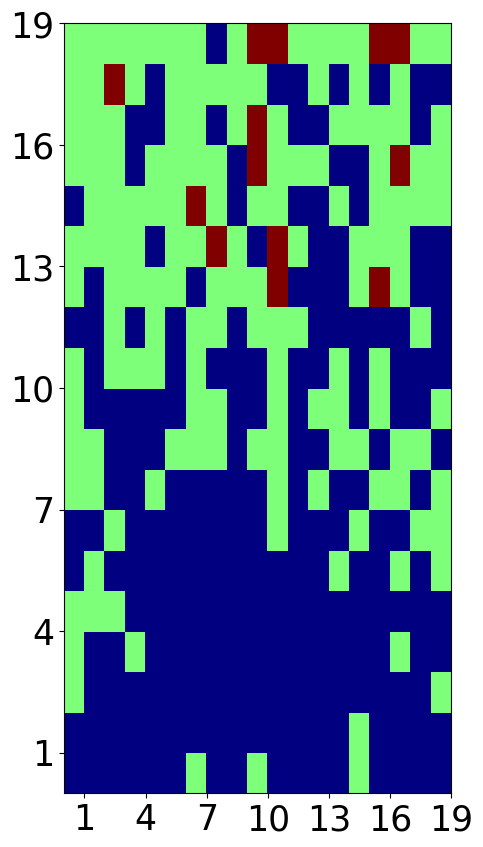

min number of recoveries 0, max number of recoveries 2


In [44]:

def plot_2_imgs(rho, rho_hat,ind=9,figsize=12,scaling='Linf',font_size=50, Single=False, xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    if Single:
        figsize=(figsize,2*figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=figsize)

    else:
        figsize=(figsize*2,figsize)
        fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)

    tick_params = {'labelsize': font_size}
    if not Single:
        output=rho.squeeze()
        ax=axes[0]
        output=output[ind,:]
        if scaling=="Linf":
            output=output/torch.max(torch.abs(cat2complex(output)))
        elif scaling=="L1":
            output=output/torch.sum(torch.abs(cat2complex(output)))
        img=torch.abs(cat2complex(output.squeeze())).view(xpix, ypix)
        pcol1=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar_used=plt.colorbar(pcol1,ax=ax)

    #plt.title('true', fontsize=font_size)
        cbar_used.ax.tick_params(labelsize=font_size)
        ax.tick_params(axis='both', **tick_params)
        
        #if scaling=="Linf":
        cbar_used.remove()
            


    output=rho_hat.squeeze() 
    output=output[ind,:]
    if scaling=="Linf":

        output=output/torch.max(torch.abs((output)))
    elif scaling=="L1":
        output=output/torch.sum(torch.abs((output)))
    img=torch.abs((output.squeeze())).view(xpix, ypix)
    if not Single:
        ax=axes[1]
    else:
        ax=plt.gca()
    pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
    cbar=plt.colorbar(pcol2, ax=ax)
#plt.title('true', fontsize=font_size)
    #ax.set_title('Full model', fontsize=font_size)
    if not Single:  
        cbar.mappable.set_clim(*cbar_used.mappable.get_clim())
    elif Lclim!=None:
        cbar.mappable.set_clim(Lclim, Hclim)
        cbar.remove()
    #cbar.remove()
    #ax.tick_params(axis='both', **tick_params)
    ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
    
    #ax.set_yticks( ticks=[1,4,7,10,13,16,19,22,25,28,31,34,37,], minor=False)
    #cbar.ax.tick_params(labelsize=font_size)
    ax.tick_params(axis='both', **tick_params)

    #ax.tick_params(labelsize=font_size)
    if file_name!=None:
        plt.savefig(file_name)
    plt.show()

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=indivual_recoveries
#rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

#plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=20, Single=True, Lclim=0, Hclim=100,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/NoGelmaImagehisto_K361.pdf')
#plot_2_imgs(rho, rho_hat[:, :361],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=34,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/2medreal_NoGelmaImagehisto_K1024_med1.pdf')
#plot_2_imgs(rho, rho_hat[:, 361:],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=34,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/2medreal_NoGelmaImagehisto_K1024_med2.pdf')
plot_2_imgs(rho, rho_hat[:, :361],ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=2,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/2medreal_NoGelmaImagehisto_K1024_med1.pdf')

print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [40]:
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')
for i in range(10):
    print(len(indivual_recoveries[indivual_recoveries>i]))

min number of recoveries 44, max number of recoveries 93
361
361
361
361
361
361
361
361
361
361


In [ ]:
#NO Gelma seed0
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_guassian_05perc_offgrid_all_seeds/PNAS-lowcoh_regime_guassian_05perc_offgrid_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/50_05pertgrid_NoGelma.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.00005,.03,50)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//400}')
for i in range(400):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-400]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-400]-sorted_cluster_sizes[-401])
                next_largest_cluster.append(sorted_cluster_sizes[-401])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-400])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=399:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list

for min_centers in [3]:
    num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, min_centers)
    num_recovered_list=num_recovered_list_CORES
    if len(eps_list)>0:
        plt.figure()
        plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        R=-1
        L=1
        #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
        plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
        plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

        plt.legend()
        plt.show()
        plt.figure()
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
        plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
        plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
        plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
        plt.legend()

        plt.show()
        #plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}.pdf')
        #plt.close()#Takes 7 minouts to run
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*400
total_num_cols=0
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(400):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/400)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/400))**2/(p_hat*(total_num_cols/400)) for i in range(400)]
sum(TS_list), chi2.cdf(sum(TS_list), 399)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 400))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 400))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25, Single=True, Lclim=0, Hclim=60)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [ ]:

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_guassian_05perc_offgrid_all_seeds/PNAS-lowcoh_regime_guassian_05perc_offgrid_seed0')


medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000










decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/50_05pertgrid_NoGelma.csv')
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


indivual_recoveries=[0]*400
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(400):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
num_times_recovered

In [ ]:
col_list.shape, medium.T.shape

In [ ]:

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/Ktests.csv')
Dict_sizes=[16384.0*2,4096*2, 1024*2,400*2, 361*2]
#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats,Dict_sizes):


    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder, Dict_size in zip(decoder_locats, Dict_sizes):
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

for j in range(len(decoder_locats)):
    num_times_recovered_list=0
    num_times_recovered=0
    indivual_recoveries=[0]*361
    col_list=get_cluster_data([decoder_locats[j]], [Dict_sizes[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


    Pop_mean=num_times_recovered/(total_num_cols)
    #indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
    indivual_recoveries=np.array(indivual_recoveries)
    p_hat=Pop_mean
    expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
    TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
    sum(TS_list), chi2.cdf(sum(TS_list), 360)





    rho=np.array(TS_list)

    rho_hat=np.zeros((2, 361))

    rho_hat[0, :]=np.array(TS_list)
    rho=torch.tensor(rho)
    rho_hat=torch.tensor(rho_hat)
    #rho[22+20]=1
    #rho[400-22-1-20]=1
    #rho[400-37-1-20]=1
    #rho[210]=1

    #H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




    rho=np.array(TS_list)

    rho_hat=np.zeros((2, 361))

    rho_hat[0, :]=indivual_recoveries
    rho=torch.tensor(rho)
    rho_hat=torch.tensor(rho_hat)
    #rho[22+20]=1
    #rho[400-22-1-20]=1
    #rho[400-37-1-20]=1
    #rho[210]=1

    H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=14)
    print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [ ]:
decoder_locats, timescampstrs

In [ ]:
L=1
R=250
plt.plot(eps_linspace[L:R], num_clusters[L:R], label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[L],eps_linspace[R], colors='r', linestyles='dashed', label='True number of columns')

In [ ]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN


%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
if False: #This vlock is from betas sweep. good betas. Not optimal.
    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_0_'
    timescampstrs={'07-14-29','09-46-07','14-35-38','13-49-42','09-45-53'} #they located in above or below
    #            curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]



if True:#This block is from tests done with all default (pytorch) parameters


    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
    timescampstrs = [
    "44_00-31-12",
    "47_00-31-10",
    "43_18-10-40",
    "46_18-10-39",
    "41_18-10-04",
    "49_18-00-09",
    "48_11-52-40",
    "45_11-50-38",
    "42_11-50-21",
    "40_11-49-46",
    "25_8-6-24",
    "24_01-54-27",
    "9_21-43-17",
    "4_21-42-58",
    "23_17-55-08",
    "29_15-29-37",
    "39_15-11-34",
    "34_15-09-31",
    "8_13-43-00",
    "3_13-42-41",
    "22_09-55-47",
    "38_08-50-47",
    "33_08-47-54",
    "28_08-46-30",
    "7_05-43-01",
    "2_05-42-47",
    "37_02-29-47",
    "32_2-26-51",
    "27_2-25-22",
    "21_01-56-27",
    "6_21-43-02",
    "1_21-42-47",
    "36_20-08-25",
    "31_20-05-29",
    "26_20-04-14",
    "20_17-57-14",
    "35_13-47-33",
    "30_13-44-32",
    "5_13-43-10",
    "0_13-42-53",
    "19_11-58-46",
    "18_8-27-31",
    "17_5-3-27",
    "16_01-39-09",
    "15_22-14-51",
    "14_17-34-09",
    "13_12-36-21",
    "12_9-12-21",
    "11_05-47-25",
    "10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'


decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        #print(medium_hat.shape)
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))
X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
num_clusters=[]
eps_linspace=np.linspace(.0001,.,100)
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

for eps in eps_linspace:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(torch_inner)

    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster=[]
    #for i in range(max(DBSCAN_fit.labels_)):
        #X_in_cluster=X[DBSCAN_fit.labels_==i]
        #dist_matrix=distance_matrix(X_in_cluster, X_in_cluster)
        #max_dist_in_cluster=np.max(dist_matrix)
        #dist=sum((X_in_cluster[0]-X_in_cluster[1])**2)**(1/2)
        #dist_in_cluster.append(max_dist_in_cluster)
    # if len(X[DBSCAN_fit.labels_==i])>1:
    #     dist_in_cluster.append(np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1))
    # else:
    #     dist_in_cluster.append(0)
    #dist_in_cluster#=[np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1)) for i in range(max(DBSCAN_fit.labels_))]
    #dist_in_cluster.sort()
    #plt.plot([i for i in range(len(dist_in_cluster))], dist_in_cluster)
    num_clusters.append(len(cluster_sizes))
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_linspace, num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')

In [ ]:
plt.plot(eps_linspace[4:], num_clusters[4:], label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')


In [ ]:
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)

T_hold=.99

IND=1
print(eps_linspace[IND], num_clusters[IND])
DBSCAN_fit=DBSCAN(eps=eps_linspace[IND], min_samples=4, metric='precomputed').fit(torch_inner)

ghat_list=[X[DBSCAN_fit.labels_==i][0] for i in range(max(DBSCAN_fit.labels_))]
ghat_list_avgs=[oreinted_mean(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]



medium_hat=np.vstack(ghat_list)
medium_hat=H.cat2complex(medium_hat)
medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

medium_hat_avgs=np.vstack(ghat_list_avgs)
medium_hat_avgs=H.cat2complex(medium_hat_avgs)
medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
max_inners_avgs=np.max(torch_inners_avgs, axis=0)
print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])


In [ ]:
ind_not_recovered_list


In [ ]:
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)

T_hold=.99
IND=-26
num_recovered_list=[]

print(eps_linspace[IND], num_clusters[IND])
ind_not_recovered_list=[]
for eps in eps_linspace:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(torch_inner)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    sorted_cluster_sizes=sorted(cluster_sizes)
    try:
        min_accepted_cluster_size=sorted_cluster_sizes[-361]
    except:
        min_accepted_cluster_size=0
    if len(cluster_sizes)>min_accepted_cluster_size:
        ghat_list=[]
        ghat_list_avgs=[]
        for i in range(max(DBSCAN_fit.labels_)):
            if cluster_sizes[i]>=5:
                
                ghat_list.append(X[DBSCAN_fit.labels_==i][0])
                ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))



        medium_hat=np.vstack(ghat_list)
        medium_hat=H.cat2complex(medium_hat)
        medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        max_inners=np.max(torch_inners, axis=0)
        #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
        #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

        medium_hat_avgs=np.vstack(ghat_list_avgs)
        medium_hat_avgs=H.cat2complex(medium_hat_avgs)
        medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
        torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
        max_inners_avgs=np.max(torch_inners_avgs, axis=0)
        #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
        #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
        num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
        if len(max_inners_avgs[max_inners_avgs>T_hold])>=360:
            ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

plt.plot(eps_linspace[:len(num_recovered_list)], num_recovered_list, label='Recovery number of columns')
plt.hlines(19**2, eps_linspace[0],eps_linspace[len(num_recovered_list)], colors='r', linestyles='dashed', label='True number of columns')        
#ind_not_recovered_list=[i[0] for i in ind_not_recovered_list]

#print(f'indices missed:{set(ind_not_recovered_list)}')
#plt.hists(ind_not_recovered_list)                    
                            

In [ ]:
print(sorted_cluster_sizes[:15], len(sorted_cluster_sizes))


In [ ]:
ghat_list=[]
print(cluster_sizes)
for i in range(len(cluster_sizes)):
    if cluster_sizes[i]>4:
        ghat_list.append(X[DBSCAN_fit.labels_==i][0])

medium_hat=np.vstack(ghat_list)
medium_hat=H.cat2complex(medium_hat)   
print(medium_hat.shape)

torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
print(max_inners[0],max(torch_inners[:,0]))
len(max_inners[max_inners>.99]),max_inners.mean()

In [ ]:
T_hold=.9
IND=num_clusters.index(19**2)
print(eps_linspace[IND], num_clusters[IND])
DBSCAN_fit=DBSCAN(eps=eps_linspace[IND], min_samples=5, metric='precomputed').fit(torch_inner)

ghat_list=[X[DBSCAN_fit.labels_==i][0] for i in range(max(DBSCAN_fit.labels_))]
ghat_list_avgs=[np.mean(X[DBSCAN_fit.labels_==i],axis=0) for i in range(max(DBSCAN_fit.labels_))]



medium_hat=np.vstack(ghat_list)
medium_hat=H.cat2complex(medium_hat)
medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

medium_hat_avgs=np.vstack(ghat_list_avgs)
medium_hat_avgs=H.cat2complex(medium_hat_avgs)
medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
max_inners_avgs=np.max(torch_inners_avgs, axis=0)
print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')


In [ ]:

index_list=[]
sum_max_inner_original=0
max_list=[]
for i in range(361):
    max_list.append(max(torch_inners[:, i]))
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/361

min(max_inners),max_avg_inners_original,len(index_list),min(max_list)

In [ ]:
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break
col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered=len(inn_list[inn_list>.99])
    num_times_recovered_list.append(num_times_recovered)
    if num_times_recovered<=12:
        print(i, num_times_recovered)

#num_times_recovered_list=sorted(num_times_recovered_list)
#num_times_recovered_list[:5]
x_values = [i for i in range(len(num_times_recovered_list))]

# Create the bar chart
plt.bar(x_values, num_times_recovered_list, width=1.0)# plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/num_times_recovered_list.pdf')

print(num_times_recovered_list[:5],)

In [ ]:
figsize=8
font_size=12
data=col_list=get_cluster_data(decoder_locats)
data=data[:361]

torch_inners=np.abs(np.inner(data,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
data=[max(torch_inners[:, i]) for i in range(int(outdim*2))]
counts, bins = np.histogram(data, bins=[.01*i for i in range(101)])
#elif min(data)<.75:
#    counts, bins = np.histogram(data, bins=[.01*i+.5 for i in range(51)])
#else:
#    counts, bins = np.histogram(data, bins=[.01*i+.75 for i in range(26)])

plt.close()

figsize=(figsize,figsize)
#fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=figsize)
tick_params = {'labelsize': font_size}

plt.hist(data, bins=bins)
plt.xticks(fontsize=12)
plt.xlim(.5,1)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/single_inners_hist.pdf')


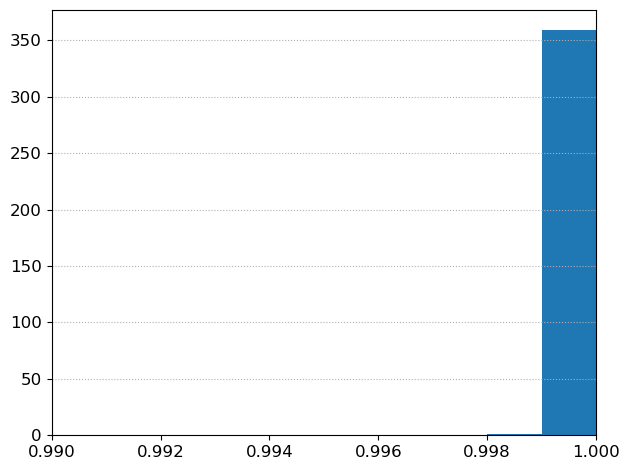

In [12]:
col_list=get_cluster_data(decoder_locats)
figsize=8
font_size=12

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
num_clusters=[]
ind_not_recovered_list=[]
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
num_recovered_list=[]
num_recovered_list_97=[]
eps_list=[]

for eps in [.01]:
    DBSCAN_fit=DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(torch_inner)
    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    sorted_cluster_sizes=sorted(cluster_sizes)
    try:
        min_accepted_cluster_size=sorted_cluster_sizes[-361]
    except:
        min_accepted_cluster_size=0
    if len(cluster_sizes)>0:
        ghat_list=[]
        ghat_list_avgs=[]
        for i in range(max(DBSCAN_fit.labels_)):
            if cluster_sizes[i]>=min_accepted_cluster_size:
                
                ghat_list.append(X[DBSCAN_fit.labels_==i][0])
                ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))



        medium_hat=np.vstack(ghat_list)
        medium_hat=H.cat2complex(medium_hat)
        medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        max_inners=np.max(torch_inners, axis=0)
        #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
        #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

        medium_hat_avgs=np.vstack(ghat_list_avgs)
        medium_hat_avgs=H.cat2complex(medium_hat_avgs)
        medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
        torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
        max_inners_avgs=np.max(torch_inners_avgs, axis=0)
        #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
        #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')


data=max_inners_avgs
counts, bins = np.histogram(data, bins=[.001*i for i in range(900, 1000)])
#elif min(data)<.75:
#    counts, bins = np.histogram(data, bins=[.01*i+.5 for i in range(51)])
#else:
#    counts, bins = np.histogram(data, bins=[.01*i+.75 for i in range(26)])

plt.close()

figsize=(figsize,figsize)
#fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=figsize)
tick_params = {'labelsize': font_size}
counts, bins = np.histogram(data, bins=[.01*i for i in range(101)])

plt.hist(data, bins=bins)
plt.xticks(fontsize=12)
plt.xlim(.5,1)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/clustered_ghat.pdf')
plt.close()
#plt.figure()
counts, bins = np.histogram(data, bins=[.001*i for i in range(1001)])

plt.hist(data, bins=bins)
plt.xticks(fontsize=12)
plt.xlim(.99,1)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/clustered_ghat_zoomedin.pdf')
#plt.figure()


array([0.99973932, 0.99944286, 0.99917495, 0.99959012, 0.9994897 ,
       0.99987458, 0.99988622, 0.99970819, 0.99990023, 0.99991767,
       0.9999043 , 0.99986557, 0.99992088, 0.99990913, 0.99981638,
       0.9996842 , 0.99990005, 0.99962837, 0.9992025 , 0.99984587,
       0.99987006, 0.99990231, 0.99974903, 0.99975329, 0.99979832,
       0.99990126, 0.99987062, 0.99960759, 0.9997986 , 0.99982988,
       0.99983841, 0.99894154, 0.99982731, 0.99994485, 0.99985439,
       0.99991594, 0.99973173, 0.99973158, 0.9996138 , 0.99981821,
       0.99959137, 0.99992528, 0.99979958, 0.99986325, 0.99977839,
       0.99983305, 0.99975816, 0.99980984, 0.99990063, 0.99981394,
       0.99989749, 0.99989985, 0.99981565, 0.9999079 , 0.9998818 ,
       0.99989384, 0.99989539, 0.9999271 , 0.99982734, 0.99983341,
       0.99987869, 0.99988522, 0.99989698, 0.999904  , 0.99990086,
       0.99991585, 0.99977712, 0.99974944, 0.99978436, 0.99991617,
       0.99975139, 0.99992541, 0.9999191 , 0.99990871, 0.99992

In [ ]:
col_list.shape

In [ ]:
min(max_inners_avgs)

In [ ]:
col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
G_i=medium.T[0]
G_i_hats=[]

for i in col_list:
    inn_list=abs(np.inner(G_i, i.conj()))
    if inn_list>.99:
        G_i_hats.append(i)
#    num_times_recovered_list.append(num_times_recovered)

G_i_hat_distanced=[np.sum(abs(G_i_hat-G_i)**2)**(1/2) for G_i_hat in G_i_hats]
G_i_hat_inners=[abs(np.inner(G_i_hat, G_i.conj())) for G_i_hat in G_i_hats]
G_i_hat_inners.sort()
G_i_hat_distanced.sort()
G_i_hat_distanced[-5:], G_i_hat_inners[-5:]

In [ ]:
G_i_hat_distanced=[np.sum(abs(G_i_hat-G_i)**2)**(1/2) for G_i_hat in G_i_hats]
G_i_hat_inners=[abs(np.inner(G_i_hat, G_i.conj())) for G_i_hat in G_i_hats]
G_i_hat_inners.sort()
G_i_hat_distanced.sort()
G_i_hat_distanced[-5:], G_i_hat_inners[-5:]

In [ ]:
len(G_i_hat_indices), len(G_i_hat_distanced)

In [ ]:
G_i_hat_indices

In [ ]:
for i in col_list:
    if not np.allclose((abs(i)**2).sum(),1):
        print('wtf')

In [ ]:
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        

    #num_times_recovered_list=sorted(num_times_recovered_list)
    #mini, min_idx=min(num_times_recovered_list), np.argmin(num_times_recovered_list)
    rho=np.zeros((2, 361*2))
    #rho=np.zeros((400))
    #A = np.array([1, 7, 9, 2, 0.1, 17, 17, 1.5])
    k = 10

    idx = np.argpartition(inn_list_max_list, k)
    rho[0, idx[:k]]=1
    rho_hat=np.zeros((2, 361))
    
    rho_hat[0, idx[:k]]=1
    rho=torch.tensor(rho)
    rho_hat=torch.tensor(rho_hat)
    #rho[22+20]=1
    #rho[400-22-1-20]=1
    #rho[400-37-1-20]=1
    #rho[210]=1
    if j<5:
        H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)

    #plt.plot([i for i in range(361)], num_times_recovered_list)
    index_of_shittiest.append(idx[:k])
intersections=[]
index_of_shittiest=np.concatenate(index_of_shittiest)
inex_of_shittiest=list(index_of_shittiest)  
num_inter=[]
for i in set(inex_of_shittiest):
    if list(index_of_shittiest).count(i)>1:
        intersections.append(i)
        num_inter.append(list(index_of_shittiest).count(i))

#index_of_shittiest=np.concatenate(index_of_shittiest)

In [ ]:
Pop_mean=num_times_recovered/(50*361)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*50])
TS_list=[(indivual_recoveries[i]-p_hat*50)**2/(p_hat*50) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)




In [21]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

In [ ]:
index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(50*361)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*50])
TS_list=[(indivual_recoveries[i]-p_hat*50)**2/(p_hat*50) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)

In [ ]:
rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries/50
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)

In [ ]:
curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_0_11-00-47.pt'
curr_encoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/enocder_5000_0_11-00-47.pt'
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
pixels='Gaussian_abs'
training_data=H.data_rho_loaded(data_path+'/train',5000/80000, pixels=pixels, normalize=False)

DICTIONARY_size=800
layers=[4096, 2048]

decoder=M.norm_linear_complex(800, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
Complex_eye=torch.cat((torch.eye(int(DICTIONARY_size/2)), torch.zeros((int(DICTIONARY_size/2),int(DICTIONARY_size/2)))), dim=1)
training_data=H.data_rho_loaded(data_path+'/train',800/80000, pixels=pixels, normalize=False)

encoder=M.fc_net_extra(int(training_data.b[0].shape[0]/2), layers,DICTIONARY_size/2, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None,dropout=.5)



decoder.load_state_dict(torch.load(curr_decoder))
encoder.load_state_dict(torch.load(curr_encoder))
encoder.to(device)
rho_hat=encoder(training_data.b.to(device)).squeeze()
print(f'support rhohat: {len(set(rho_hat.nonzero(as_tuple=True)[1].cpu().detach().numpy()))}')
medium_hat=decoder(Complex_eye).squeeze()
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat
#col_list=get_cluster_data(single)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break
#col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered=len(inn_list[inn_list>.99])
    col_list[inn_list>.99]=0
    num_times_recovered_list.append(num_times_recovered)
    #if num_times_recovered<=12:
    #    print(i, num_times_recovered)

#num_times_recovered_list=sorted(num_times_recovered_list)
#num_times_recovered_list[:5]
x_values = [i for i in range(len(num_times_recovered_list))]

# Create the bar chart
plt.bar(x_values, num_times_recovered_list, width=1.0)# plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
#plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/num_times_recovered_list.pdf')

print(num_times_recovered_list[:5],)


In [ ]:
curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_0_19-05-41.pt'
curr_encoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/enocder_5000_0_19-05-41.pt'
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
pixels='Gaussian_abs'
training_data=H.data_rho_loaded(data_path+'/train',5000/80000, pixels=pixels, normalize=False)

DICTIONARY_size=32768
layers=[4096, 2048]


decoder=M.norm_linear_complex(DICTIONARY_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
Complex_eye=torch.cat((torch.eye(int(DICTIONARY_size/2)), torch.zeros((int(DICTIONARY_size/2),int(DICTIONARY_size/2)))), dim=1)
training_data=H.data_rho_loaded(data_path+'/train',800/80000, pixels=pixels, normalize=False)

encoder=M.fc_net_extra(int(training_data.b[0].shape[0]/2), layers,DICTIONARY_size/2, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None,dropout=.5)



decoder.load_state_dict(torch.load(curr_decoder))
encoder.load_state_dict(torch.load(curr_encoder))
encoder.to(device)
rho_hat=encoder(training_data.b.to(device)).squeeze()
print(f'support rhohat: {len(set(rho_hat.nonzero(as_tuple=True)[1].cpu().detach().numpy()))}')
medium_hat=decoder(Complex_eye).squeeze()
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat
#col_list=get_cluster_data(single)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break
#col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered=len(inn_list[inn_list>.99])
    col_list[inn_list>.99]=0
    num_times_recovered_list.append(num_times_recovered)
    #if num_times_recovered<=12:
    #    print(i, num_times_recovered)

#num_times_recovered_list=sorted(num_times_recovered_list)
#num_times_recovered_list[:5]
x_values = [i for i in range(len(num_times_recovered_list))]

# Create the bar chart
plt.bar(x_values, num_times_recovered_list, width=1.0)# plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
#plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/num_times_recovered_list.pdf')

print(num_times_recovered_list[:5],)


In [ ]:
curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_0_19-05-41.pt'
curr_encoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/enocder_5000_0_19-05-41.pt'
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
pixels='Gaussian_abs'
training_data=H.data_rho_loaded(data_path+'/train',5000/80000, pixels=pixels, normalize=False)

DICTIONARY_size=32768
layers=[4096, 2048]

decoder=M.norm_linear_complex(DICTIONARY_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
Complex_eye=torch.cat((torch.eye(int(DICTIONARY_size/2)), torch.zeros((int(DICTIONARY_size/2),int(DICTIONARY_size/2)))), dim=1)
training_data=H.data_rho_loaded(data_path+'/train',800/80000, pixels=pixels, normalize=False)

encoder=M.fc_net_extra(int(training_data.b[0].shape[0]/2), layers,DICTIONARY_size/2, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None,dropout=.5)



decoder.load_state_dict(torch.load(curr_decoder))
encoder.load_state_dict(torch.load(curr_encoder))
encoder.to(device)
rho_hat=encoder(training_data.b.to(device)).squeeze()
print(f'support rhohat: {len(set(rho_hat.nonzero(as_tuple=True)[1].cpu().detach().numpy()))}')
medium_hat=decoder(Complex_eye).squeeze()
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat
#col_list=get_cluster_data(single)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break
#col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered=len(inn_list[inn_list>.99])
    col_list[inn_list>.99]=0
    num_times_recovered_list.append(num_times_recovered)
    #if num_times_recovered<=12:
    #    print(i, num_times_recovered)

#num_times_recovered_list=sorted(num_times_recovered_list)
#num_times_recovered_list[:5]
x_values = [i for i in range(len(num_times_recovered_list))]

# Create the bar chart
plt.bar(x_values, num_times_recovered_list, width=1.0)# plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
#plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/num_times_recovered_list.pdf')
num_times_recovered_list=sorted(num_times_recovered_list)
print(num_times_recovered_list[:5],)
shite_vectors=[]
for i in range(len(col_list)):
    if col_list[i].sum()!=0:
        shite_vectors.append(col_list[i])
shite_vectors=np.array(shite_vectors)
inn_list=abs(np.inner(medium.T, shite_vectors.conj()))


print(f'There are {len(shite_vectors)} that are not in the true dictionary. The maximum inner product with them and the true dictionary is: {np.max(inn_list)}')

medium_hat=decoder(Complex_eye).squeeze()
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat
eps_linspace=np.linspace(.00005,.05,50)

num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,eps_list=DBSCAN_inners_fig(col_list, 5)
if len(eps_list)>0:
    plt.figure()
    plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)# Add subticks to the y-axis
    plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
    plt.tight_layout()
    R=-1
    L=1
    #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
    #plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')

    #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')

    plt.legend()
    plt.show()

In [ ]:
L=1
R=-1

plt.figure()
plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
#plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()

plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
#plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97')
#plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns not recovered (<.95)')
plt.plot(eps_list[L:R], num_recovered_list_CORES[L:R], label='Number of columns recovered by cores')



#plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
#plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')

plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_0_19-05-41.pt'
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
DICTIONARY_size=32768
layers=[4096, 2048]
decoder=M.norm_linear_complex(DICTIONARY_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
Complex_eye=torch.cat((torch.eye(int(DICTIONARY_size/2)), torch.zeros((int(DICTIONARY_size/2),int(DICTIONARY_size/2)))), dim=1)
decoder.load_state_dict(torch.load(curr_decoder))



medium_hat=decoder(Complex_eye).squeeze()
print(medium_hat.shape)
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat

    #col_list=get_cluster_data([decoder_locats[j]])
num_times_recovered_list=[]
inn_list_max_list=[]
num_times_recovered=0
#indivual_recoveries=[0]*361
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered+=len(inn_list[inn_list>.99])
    num_times_recovered_list.append(len(inn_list[inn_list>.99]))
    #num_times_recovered+=len(inn_list[inn_list>.99])
    #indivual_recoveries[i]+=len(inn_list[inn_list>.99])

Pop_mean=num_times_recovered/(len(medium_hat))
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(num_times_recovered_list)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*len(medium_hat)/361])
TS_list=[(indivual_recoveries[i]-p_hat*50)**2/(p_hat*50) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)

In [ ]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_0_19-04-58.pt'

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
DICTIONARY_size=32768/4
layers=[4096, 2048]
decoder=M.norm_linear_complex(DICTIONARY_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
Complex_eye=torch.cat((torch.eye(int(DICTIONARY_size/2)), torch.zeros((int(DICTIONARY_size/2),int(DICTIONARY_size/2)))), dim=1)
decoder.load_state_dict(torch.load(curr_decoder))



medium_hat=decoder(Complex_eye).squeeze()
print(medium_hat.shape)
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat

    #col_list=get_cluster_data([decoder_locats[j]])
num_times_recovered_list=[]
inn_list_max_list=[]
num_times_recovered=0
#indivual_recoveries=[0]*361
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered+=len(inn_list[inn_list>.99])
    num_times_recovered_list.append(len(inn_list[inn_list>.99]))
    #num_times_recovered+=len(inn_list[inn_list>.99])
    #indivual_recoveries[i]+=len(inn_list[inn_list>.99])

Pop_mean=num_times_recovered/(len(medium_hat))
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(num_times_recovered_list)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*len(medium_hat)/361])
TS_list=[(indivual_recoveries[i]-p_hat*50)**2/(p_hat*50) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)

In [ ]:
shite_vectors=[]
for i in range(len(col_list)):
    if col_list[i].sum()!=0:
        shite_vectors.append(col_list[i])
shite_vectors=np.array(shite_vectors)
inn_list=abs(np.inner(medium.T, shite_vectors.conj()))


print(f'There are {len(shite_vectors)} that are not in the true dictionary. The maximum inner product with them and the true dictionary is: {max(inn_list})


In [ ]:
shite_vectors.shape

Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
(806, 722)
Medium: (806, 361), Rho: (800, 361), B: (800, 806)
support rhohat: 2048
(1024, 806)
shape of the union without removin: (1024, 806), number for Expceriments: 2
(806,)
There are 37 that are not in the true dictionary. The maximum inner product with them and the true dictionary is: 0.9895793952614081
(1024, 806)


/tmp/ipykernel_1642983/871202298.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rho=torch.tensor(rho)


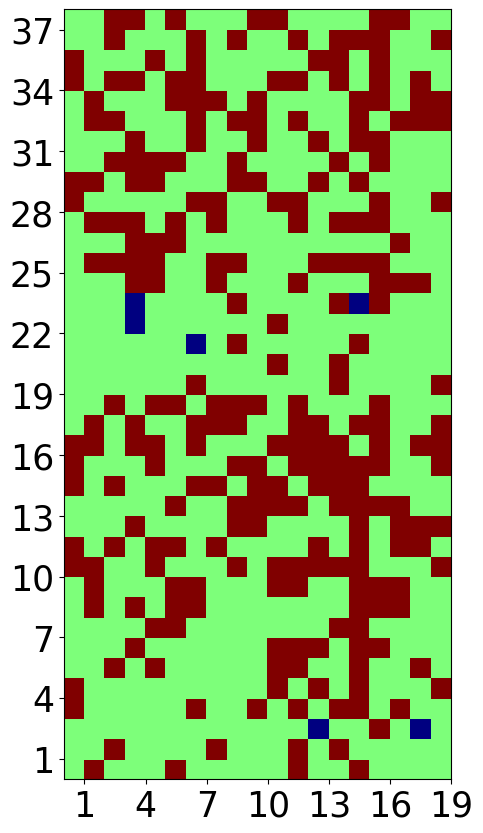

In [43]:
curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_0_00-37-19.pt'
curr_encoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/enocder_5000_0_00-37-19.pt'
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
pixels='Gaussian_abs'
training_data=H.data_rho_loaded(data_path+'/train',5000/80000, pixels=pixels, normalize=False)

DICTIONARY_size=2048
layers=[4096, 2048]



data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium.T
print(medium.shape)

decoder=M.norm_linear_complex(DICTIONARY_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
Complex_eye=torch.cat((torch.eye(int(DICTIONARY_size/2)), torch.zeros((int(DICTIONARY_size/2),int(DICTIONARY_size/2)))), dim=1)
training_data=H.data_rho_loaded(data_path+'/train',800/80000, pixels=pixels, normalize=False)

encoder=M.fc_net_extra(int(training_data.b[0].shape[0]/2), layers,DICTIONARY_size/2, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None,dropout=.5)



decoder.load_state_dict(torch.load(curr_decoder))
encoder.load_state_dict(torch.load(curr_encoder))
encoder.to(device)
rho_hat=encoder(training_data.b.to(device)).squeeze()
print(f'support rhohat: {len(set(rho_hat.nonzero(as_tuple=True)[1].cpu().detach().numpy()))}')
medium_hat=decoder(Complex_eye).squeeze()
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat
#col_list=get_cluster_data(single)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break
#col_list=get_cluster_data(decoder_locats)
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(len(medium.T)):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    num_times_recovered=len(inn_list[inn_list>.99])
    col_list[inn_list>.99]=0
    num_times_recovered_list.append(num_times_recovered)
    #if num_times_recovered<=12:
    #    print(i, num_times_recovered)

#num_times_recovered_list=sorted(num_times_recovered_list)
#num_times_recovered_list[:5]
x_values = [i for i in range(len(num_times_recovered_list))]

# Create the bar chart
plt.bar(x_values, num_times_recovered_list, width=1.0)# plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)# Add subticks to the y-axis
plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
#plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/num_times_recovered_list.pdf')
#num_times_recovered_list=sorted(num_times_recovered_list)
#print(num_times_recovered_list[:5],)
shite_vectors=[]
for i in range(len(col_list)):
    if col_list[i].sum()!=0:
        shite_vectors.append(col_list[i])
shite_vectors=np.array(shite_vectors)
inn_list=abs(np.inner(medium.T, shite_vectors.conj()))


print(f'There are {len(shite_vectors)} that are not in the true dictionary. The maximum inner product with them and the true dictionary is: {np.max(inn_list)}')

medium_hat=decoder(Complex_eye).squeeze()
#print(medium_hat.shape)
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)    
print(medium_hat.shape)
#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, pixels=pixels, normalize=NORMALIZE)
#b_val=val_data.b.to(device)
#rho_val=val_data.rho.to(device)
col_list=medium_hat
eps_linspace=np.linspace(.00005,.05,50)
if False:
    num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,eps_list=DBSCAN_inners_fig(col_list, 5)
    if len(eps_list)>0:
        plt.figure()
        plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        R=-1
        L=1
        #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        #plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')

        #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')

        plt.legend()
        plt.show()

rho_hat=np.zeros((2, 361*2))

rho_hat[0, :]=num_times_recovered_list
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19*2, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=2,file_name='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/2medreal_NoGelmaImagehisto_K1024_med1.pdf')


In [ ]:
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium.T

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium.T

print(medium.shape)

neigh = NearestNeighbors(n_neighbors=4, radius=0.1, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

connections=neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))

In [ ]:
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')

In [ ]:
for n_neighbors in [2,3,4,5,6,7,8,9]:
    neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=0.00001, metric='precomputed')
    col_list=medium.T
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

    connections=neigh.fit(torch_inner)
    neighbors_dist, neighbors=neigh.kneighbors()
    not_split=0
    for i in range(361):
        for j in neighbors[i]:
            if j>360 and j!=i+361:
                #print(i, neighbors[i])
                not_split+=1
                break
    print(f'In {n_neighbors} nearest neirghbors, {not_split} neighborhoods contain points from both seeds')
            
print()

(806, 722)
Max_(i, j)<g_1, i, g_2, j>=0.7847237581880193
Max_(i)<g_1, i, g_2, i>=0.7847237581880193
Max_(i, j)<g_1, i, g_1, j>=0.763143828697641
Max_(i, j)<g_2, i, g_2, j>=0.7469100755630589
Max_(i, j!=i)<g_1, i, g_,2j>=0.763143828697641


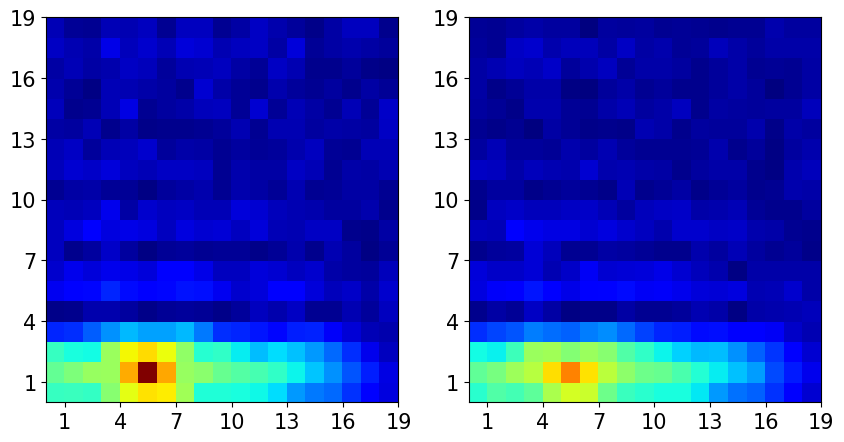

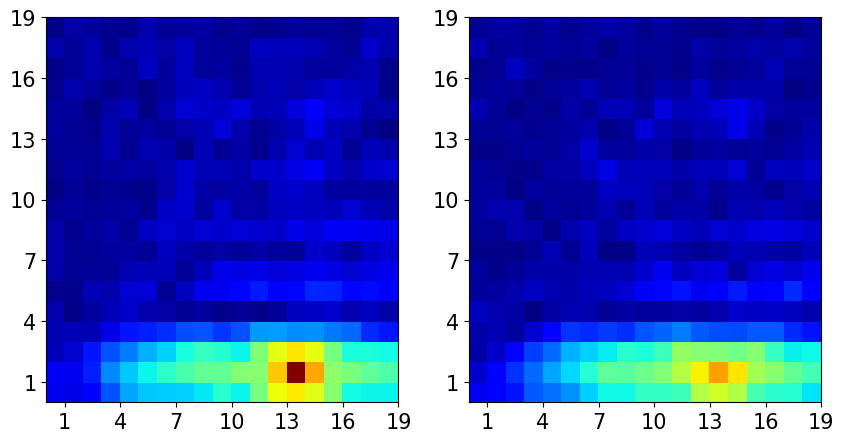

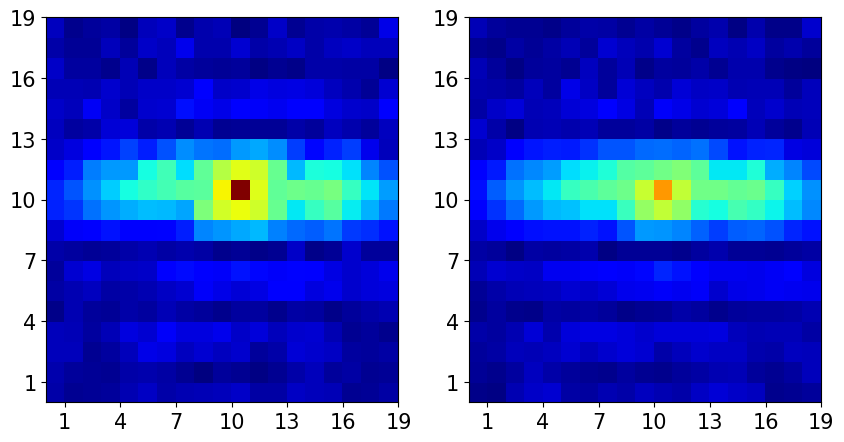

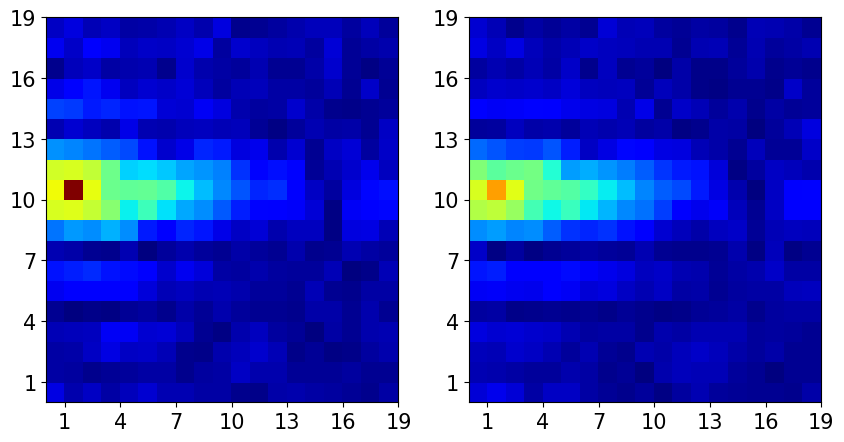

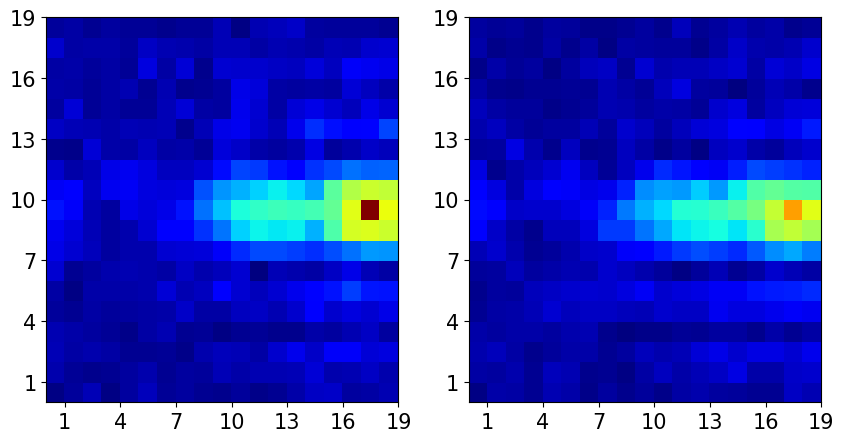

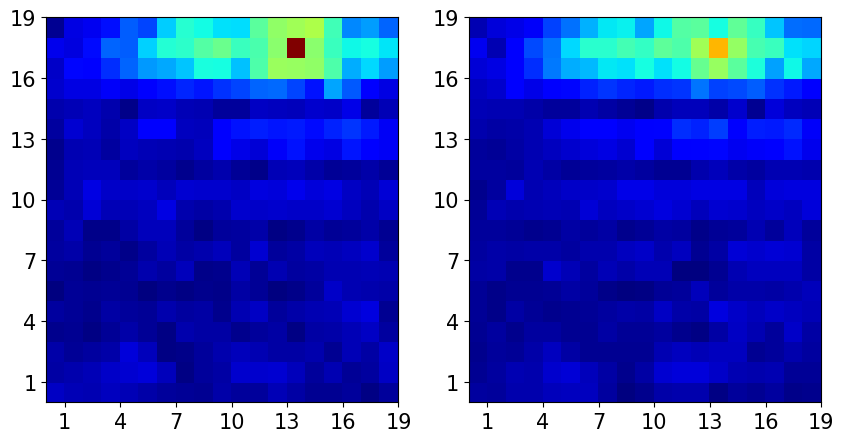

In [4]:
#IMAGES OF INNER PRODUCTS ACROSS 2 different random media
def plot_2_imgs(inners, rho_hat,ind=9,figsize=8,scaling='Linf',font_size=50, Single=False, xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    rho_hat_1=np.zeros((2, 361))
    rho_hat_1[0, :]=inners[J,:361]
    rho_hat_1=torch.tensor(rho_hat_1)


    
    rho_hat_2=np.zeros((2, 361))
    rho_hat_2[0, :]=inners[J,361:]
    #rho=torch.tensor(rho)
    rho_hat_2=torch.tensor(rho_hat_2)




    figsize=(figsize*2,figsize)
    fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)
    rhos=[rho_hat_1,rho_hat_2]
    for i in [0,1]:
        rho_hat=rhos[i]
        tick_params = {'labelsize': font_size}
        output=rho_hat.squeeze() 
        output=output[ind,:]
        img=torch.abs((output.squeeze())).view(xpix, ypix)
        ax=axes[i]
        pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar=plt.colorbar(pcol2, ax=ax)
    #plt.title('true', fontsize=font_size)
        #ax.set_title('Full model', fontsize=font_size)
        cbar.mappable.set_clim(Lclim, Hclim)
        
        cbar.ax.tick_params(labelsize=font_size)

        #cbar.remove()
        ax.tick_params(axis='both', **tick_params)
        ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        
        #if i==0:
        cbar.remove()
    plt.show()
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium.T

print(medium.shape)


inners=medium.transpose().conjugate()@medium
inners=np.abs(inners)




coherence=0
for i in range(361):
    for j in range(361, 722):
        if inners[i][j]>coherence and i!=j:
            coherence=inners[i][j]
print(f'Max_(i, j)<g_1, i, g_2, j>={coherence}')

coherence=0
for i in range(361):
    if inners[i][i+361]>coherence and i!=j:
        coherence=inners[i][i+361]
print(f'Max_(i)<g_1, i, g_2, i>={coherence}')


coherence=0
for i in range(361):
    for j in range(361):
        if inners[i][j]>coherence and i!=j:
            coherence=inners[i][j]
print(f'Max_(i, j)<g_1, i, g_1, j>={coherence}')

coherence=0
for i in range(361,361*2):
    for j in range(361,361*2):
        if inners[i][j]>coherence and i!=j:
            coherence=inners[i][j]
print(f'Max_(i, j)<g_2, i, g_2, j>={coherence}')


coherence=0
for i in range(len(inners)):
    for j in range(len(inners[i])):
        if inners[i][j]>coherence and i!=j and j!=i+361 and j!=i-361:
            coherence=inners[i][j]
print(f'Max_(i, j!=i)<g_1, i, g_,2j>={coherence}')





neigh = NearestNeighbors(n_neighbors=1, radius=0.00001, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

connections=neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
not_split=0



J=10*19+10
rho_hat=np.zeros((2, 361))

rho_hat[0, :]=inners[J,:361]
#rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1



rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1

for J in [19+5, 19*2-6, 10*19+10, 10*19+1,10*19-2,19*18-6]:
    rho_hat=np.zeros((2, 361))

    rho_hat[0, :]=inners[J,:361]
    #rho=torch.tensor(rho)
    rho_hat=torch.tensor(rho_hat)
    plot_2_imgs(inners, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=15, Single=True, Lclim=0, Hclim=1)
rho_hat=np.zeros((2, 361))

#rho_hat[0, :]=inners[J,361:]
#rho=torch.tensor(rho)
#rho_hat=torch.tensor(rho_hat)
#plot_2_imgs(inners, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=1)



wtf they are:  False
(806, 722)
Max_(i, j)<g_1, i, g_2, j>=0.6142789713821396
Max_(i)<g_1, i, g_2, i>=0.6142789713821396
Max_(i, j)<g_1, i, g_1, j>=0.763143828697641
Max_(i, j)<g_2, i, g_2, j>=0.7336245259220286
Max_(i, j!=i)<g_1, i, g_,2j>=0.763143828697641


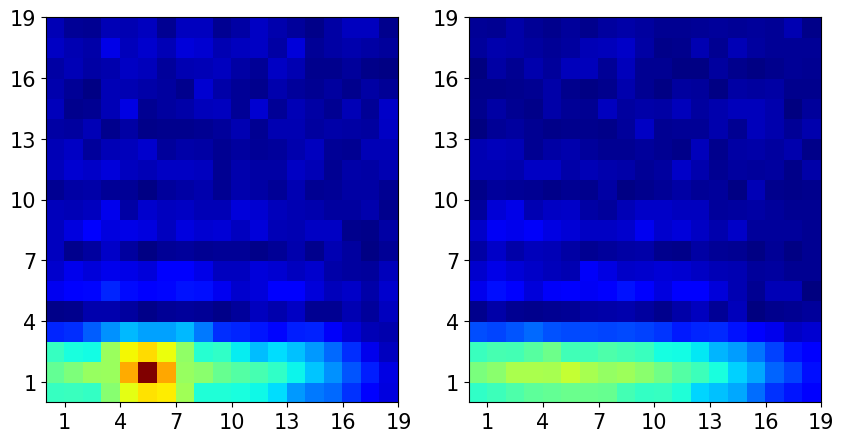

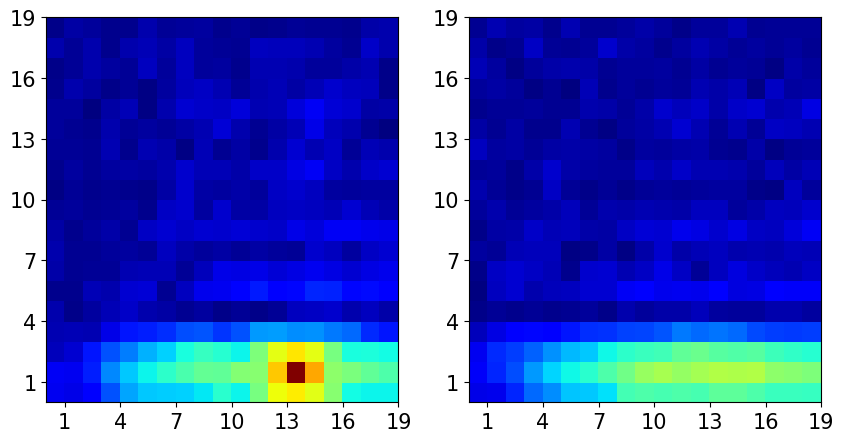

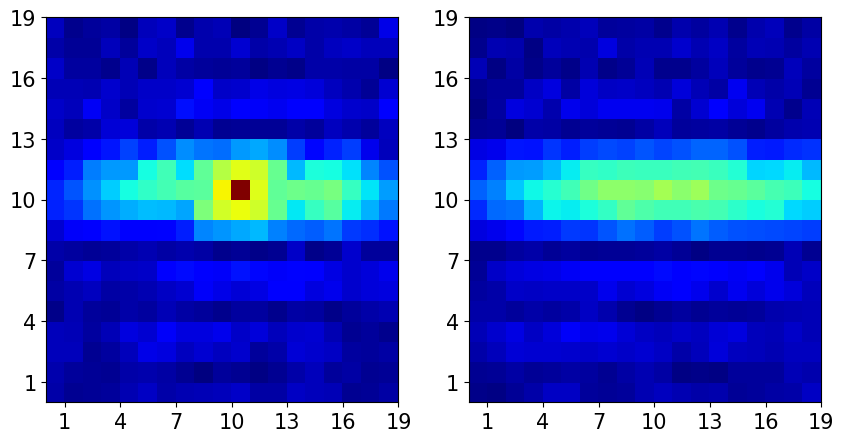

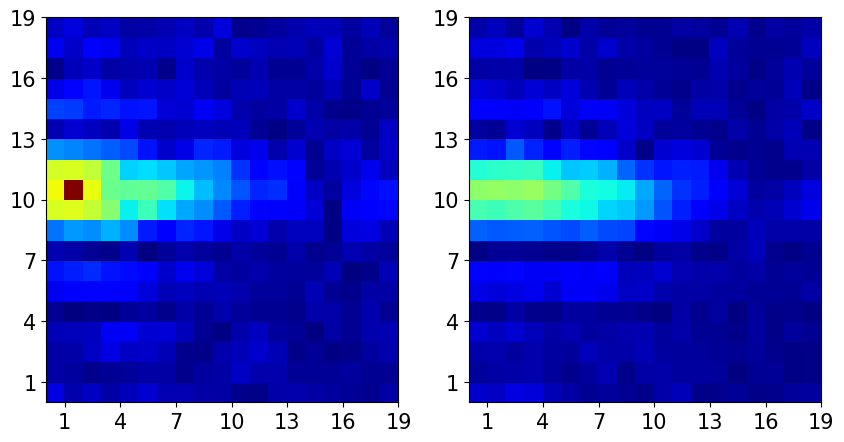

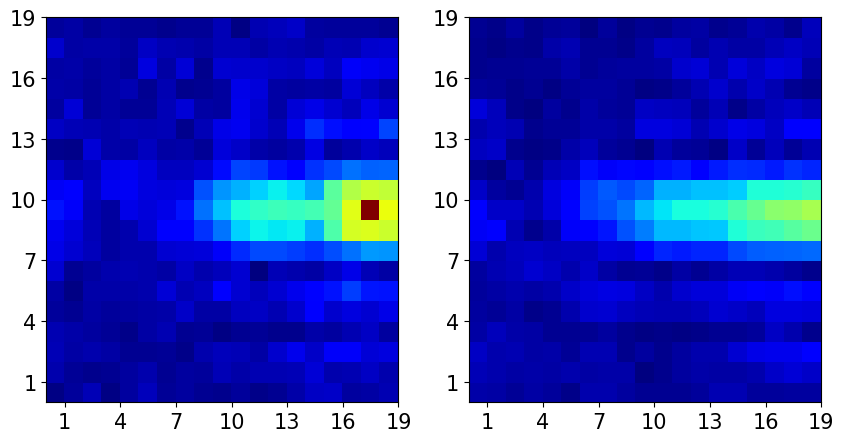

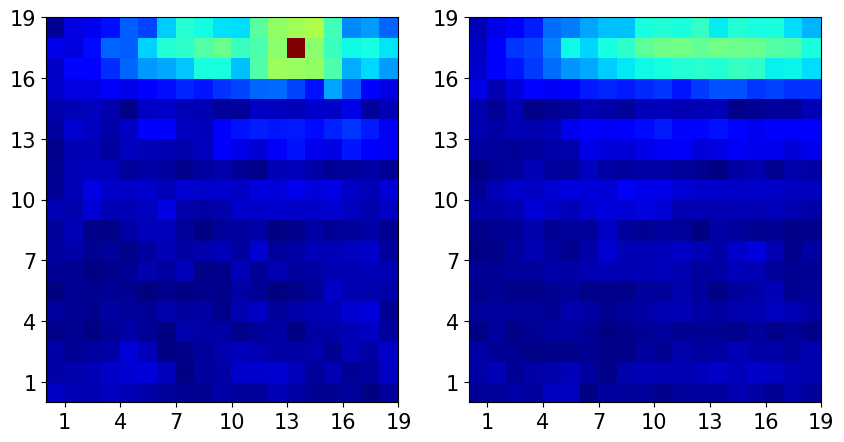

In [10]:
#IMAGES OF INNER PRODUCTS ACROSS 2 different random media
def plot_2_imgs(inners, rho_hat,ind=9,figsize=8,scaling='Linf',font_size=50, Single=False, xpix=31, ypix=21, file_name=None, Lclim=None, Hclim=None):
    plt.close()
    rho_hat_1=np.zeros((2, 361))
    rho_hat_1[0, :]=inners[J,:361]
    
    rho_hat_1=torch.tensor(rho_hat_1)


    
    rho_hat_2=np.zeros((2, 361))
    rho_hat_2[0, :]=inners[J,361:]
    #rho=torch.tensor(rho)
    rho_hat_2=torch.tensor(rho_hat_2)




    figsize=(figsize*2,figsize)
    fig, axes=plt.subplots(nrows= 1, ncols= 2,figsize=figsize)
    rhos=[rho_hat_1,rho_hat_2]
    for i in [0,1]:
        rho_hat=rhos[i]
        tick_params = {'labelsize': font_size}
        output=rho_hat.squeeze() 
        output=output[ind,:]
        img=torch.abs((output.squeeze())).view(xpix, ypix)
        ax=axes[i]
        pcol2=ax.pcolor(img.detach().cpu(),cmap='jet')
        cbar=plt.colorbar(pcol2, ax=ax)
    #plt.title('true', fontsize=font_size)
        #ax.set_title('Full model', fontsize=font_size)
        cbar.mappable.set_clim(Lclim, Hclim)
        
        cbar.ax.tick_params(labelsize=font_size)

        #cbar.remove()
        ax.tick_params(axis='both', **tick_params)
        ax.set_xticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        ax.set_yticks( ticks=[1,4,7,10,13,16,19], minor=False)#, font_size=font_size)
        
        #if i==0:
        cbar.remove()
    plt.show()
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed2')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print("wtf they are: ", np.allclose(medium1,medium2))
medium=np.concatenate((medium1.T, medium2.T), axis=0)
medium=medium.T

print(medium.shape)


inners=medium.transpose().conjugate()@medium
inners=np.abs(inners)




coherence=0
for i in range(361):
    for j in range(361, 722):
        if inners[i][j]>coherence and i!=j:
            coherence=inners[i][j]
print(f'Max_(i, j)<g_1, i, g_2, j>={coherence}')

coherence=0
for i in range(361):
    if inners[i][i+361]>coherence and i!=j:
        coherence=inners[i][i+361]
print(f'Max_(i)<g_1, i, g_2, i>={coherence}')


coherence=0
for i in range(361):
    for j in range(361):
        if inners[i][j]>coherence and i!=j:
            coherence=inners[i][j]
print(f'Max_(i, j)<g_1, i, g_1, j>={coherence}')

coherence=0
for i in range(361,361*2):
    for j in range(361,361*2):
        if inners[i][j]>coherence and i!=j:
            coherence=inners[i][j]
print(f'Max_(i, j)<g_2, i, g_2, j>={coherence}')


coherence=0
for i in range(len(inners)):
    for j in range(len(inners[i])):
        if inners[i][j]>coherence and i!=j and j!=i+361 and j!=i-361:
            coherence=inners[i][j]
print(f'Max_(i, j!=i)<g_1, i, g_,2j>={coherence}')





neigh = NearestNeighbors(n_neighbors=1, radius=0.00001, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))

connections=neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
not_split=0
if False:
    for i in range(361):
        for j in neighbors[i]:
            if j>360 and j!=i+361:
                print(i, neighbors[i], [neighbors[i][k]-361 for k in range(4)])
                not_split+=1
                #break


J=10*19+10
rho_hat=np.zeros((2, 361))
rho=np.zeros(361)
rho_hat[0, :]=inners[J,:361]
#rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1



rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1

for J in [19+5, 19*2-6, 10*19+10, 10*19+1,10*19-2,19*18-6]:
    rho_hat=np.zeros((2, 361))

    rho_hat[0, :]=inners[J,:361]
    #rho=torch.tensor(rho)
    rho_hat=torch.tensor(rho_hat)
    plot_2_imgs(inners, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=15, Single=True, Lclim=0, Hclim=1)
rho_hat=np.zeros((2, 361))

#rho_hat[0, :]=inners[J,361:]
#rho=torch.tensor(rho)
#rho_hat=torch.tensor(rho_hat)
#plot_2_imgs(inners, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=1)



In [69]:
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed2')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print("wtf they are: ", np.allclose(medium1,medium2))
print(medium1.shape, medium2.shape)
print(sum(abs(medium1.T[0])**2), sum(abs(medium2.T[0])**2))

wtf they are:  False
(806, 361) (806, 361)
1.0000000000000004 0.9999999999999991


In [53]:
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt_array.mat')['RM_realization_list'])
print(medium.shape)

medium=np.concatenate((medium1[:10]), axis=1)

#data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
#medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
#medium=np.concatenate((medium1.T, medium2.T), axis=0)

print(medium.shape)

neigh = NearestNeighbors(n_neighbors=10, radius=0.5, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
print(torch_inner.shape)
connections=neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
not_split=0
for i in range(1):
    
    print(i, neighbors[i], [neighbors[i][k]-361 for k in range(4)])
    
    break

not_split


(361, 361)
(1450, 4000)
(4000, 4000)
0 [   1   20   21  800 2800    3 2440  420  480 1240] [-360, -341, -340, 439]


0

In [ ]:
scp  /Users/alexchristie/Downloads/50_05pertgrid_NoGelma.csv achristie@gp-workstation2:/home/achristie/RM_imaging/Data/


In [ ]:
for i in range(400):
    for j in neighbors[i]:
        if j>360 and j!=i+361:
            print(i, neighbors[i], [neighbors[i][k]-361 for k in range(4)])
            not_split+=1
            #break
not_split


(806, 722)
(722, 722)
Not adjeanceny matrix
(361, 361)
(361, 361)


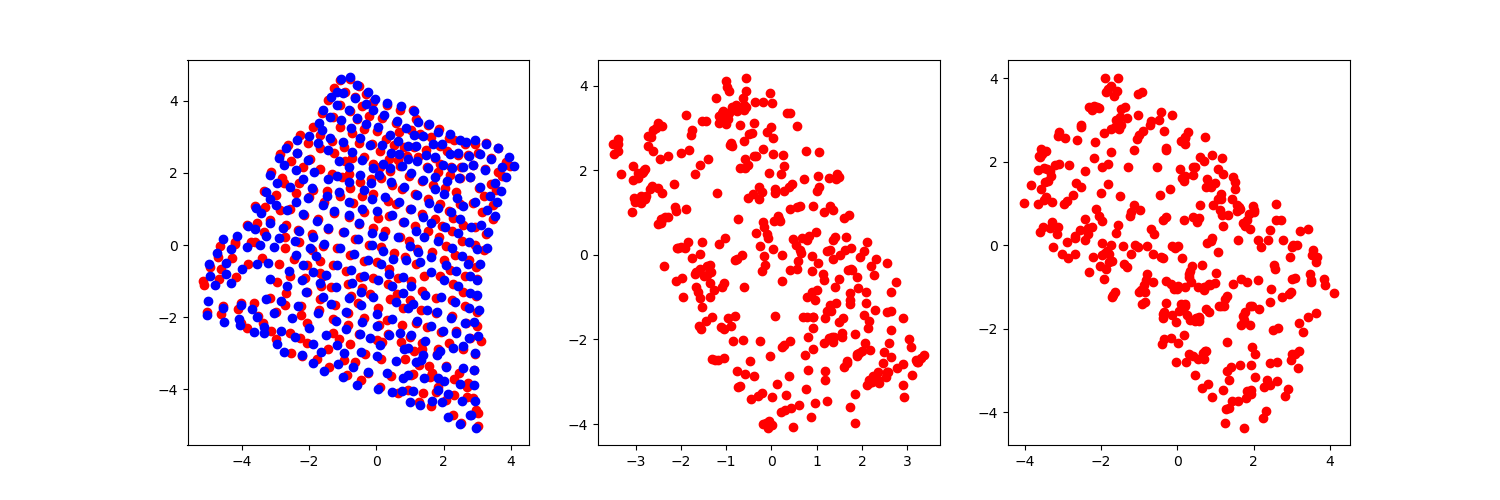

0.9996432184705697


In [52]:

from sklearn.manifold import MDS
from scipy.spatial.distance import squareform,pdist                                                              
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import procrustes
%matplotlib widget
Dim=2
n_neighbors=5
n_neighbors_single=4
EUC=True



data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
perm=np.random.permutation(722)
inverse_perm=np.argsort(perm)
OG_medium=medium.T.copy()
medium=medium[perm]
medium=medium.T
print(medium.shape)

neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=0.3, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))




neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
dist_matrix=np.zeros((722,722))
for i in range(722):
    for j in range(len(neighbors[i])):
        if not EUC:
            dist_matrix[i][neighbors[i][j]]=1
            dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
        else:
            dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
            dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]


not_split=0
for i in range(361):
    for j in neighbors[i]:
        if j>360 and j!=i+361:
            not_split+=1
            #break

A=dist_matrix
print(A.shape)
if len(A[0][A[0]>0])!=9:
    print('Not adjeanceny matrix')
A=shortest_path(A)
#print(A)
#A=A.astype(np.float64)



embedding = MDS(n_components=Dim, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(A)

embedding_medium_1 = MDS(n_components=Dim, dissimilarity='precomputed')
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=medium1
perm_med1=np.random.permutation(361)
inverse_perm_med1=np.argsort(perm_med1)
OG_medium=medium.T.copy()
medium=medium[perm_med1]
medium=medium.T
print(medium.shape)

col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
inners=medium.transpose().conjugate()@medium
inners=np.abs(inners)
neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=0.00001, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
dist_matrix=np.zeros((361,361))
for i in range(361):
    for j in range(len(neighbors[i])):
        if not EUC:
            dist_matrix[i][neighbors[i][j]]=1
            dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
        else:
            dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
            dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
not_split=0
for i in range(361):
    for j in neighbors[i]:
        if j>360 and j!=i+361:
            not_split+=1
            #break
A=dist_matrix

A=shortest_path(A)
X_transformed_medium_1 = embedding_medium_1.fit_transform(A)


embedding_medium_2 = MDS(n_components=Dim, dissimilarity='precomputed')
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')

medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=medium2
perm_med2=np.random.permutation(361)
inverse_perm_med2=np.argsort(perm_med2)
OG_medium=medium.T.copy()
medium=medium[inverse_perm_med2]
medium=medium.T
print(medium.shape)

neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=0.3, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
inners=medium.transpose().conjugate()@medium
inners=np.abs(inners)
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
dist_matrix=np.zeros((361,361))
for i in range(361):
    for j in range(len(neighbors[i])):
        if not EUC:
            dist_matrix[i][neighbors[i][j]]=1
            dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
        else:
            dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
            dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
not_split=0
for i in range(361):
    for j in neighbors[i]:
        if j>360 and j!=i+361:
            not_split+=1
            #break
A=dist_matrix
A=shortest_path(A)

X_transformed_medium_2 = embedding_medium_1.fit_transform(A)





























#plt.scatter(X_transformed[:361,0], X_transformed[:361,1], c='r')
if Dim==3:
    plt.close()
    fig = plt.figure(figsize=(10,30))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X_transformed[inverse_perm[:361],0], X_transformed[inverse_perm[:361], 1], X_transformed[inverse_perm[:361],2], c='r')
    ax.scatter(X_transformed[inverse_perm[361:],0], X_transformed[inverse_perm[361:],1], X_transformed[inverse_perm[361:],2], c='b')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    nx, ny = (19, 19)
    x = np.linspace(0, 19, nx)
    y = np.linspace(0, 19, ny)
    xv, yv = np.meshgrid(x, y)
    target_grid=np.zeros((19*19*2, 3))
    target_grid[:19*19,0]=xv.flatten()
    target_grid[:19*19,1]=yv.flatten()
    target_grid[:19*19,2]=0

    target_grid[19*19:,0]=xv.flatten()
    target_grid[19*19:,1]=yv.flatten()
    target_grid[19*19:,2]=1


    mtx1, mtx2, disparity = procrustes(target_grid,X_transformed)
    print(disparity)
    plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(mtx2[inverse_perm[:361],0], mtx2[inverse_perm[:361], 1], mtx2[inverse_perm[:361],2], c='r')
    #ax.scatter(mtx2[361:,0], mtx2[361:,1], mtx2[361:,2], c='b')
    ax.scatter(mtx1[361:,0], mtx1[361:,1], mtx1[361:,2], c='g')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()
    

else:
    plt.close()
    fig, ax = plt.subplots(1,3, figsize=(15,5 ))
    ax[0].scatter(X_transformed[inverse_perm[:361],0], X_transformed[inverse_perm[:361], 1], c='r')
    ax[0].scatter(X_transformed[inverse_perm[361:],0], X_transformed[inverse_perm[361:],1], c='b')

    ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1, 1], c='r')
    #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1,1], c='b')

    ax[2].scatter(X_transformed_medium_2[inverse_perm_med2,0], X_transformed_medium_2[inverse_perm_med2, 1], c='r')

    plt.show()
    nx=19
    ny=19
    x = np.linspace(0, 19, nx)
    y = np.linspace(0, 19, ny)
    xv, yv = np.meshgrid(x, y)
    target_grid=np.zeros((19*19*2, 3))
    target_grid[:19*19,0]=xv.flatten()
    target_grid[:19*19,1]=yv.flatten()
    target_grid[:19*19,2]=0

    target_grid[19*19:,0]=xv.flatten()
    target_grid[19*19:,1]=yv.flatten()
    target_grid[19*19:,2]=1
    X_transformed_extened=np.zeros((722,3))
    X_transformed_extened[:,:2]=X_transformed

    mtx1, mtx2, disparity = procrustes(target_grid,X_transformed_extened)
    print(disparity)
    


In [3]:

from sklearn.manifold import MDS
from scipy.spatial.distance import squareform,pdist                                                              
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import procrustes
%matplotlib widget
Dim=3
n_neighbors=5
n_neighbors_single=4
EUC=True



data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=np.concatenate((medium1.T, medium2.T), axis=0)
perm=np.random.permutation(722)
inverse_perm=np.argsort(perm)
OG_medium=medium.T.copy()
medium=medium[perm]
medium=medium.T
print(medium.shape)

neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=0.3, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))




neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
dist_matrix=np.zeros((722,722))
for i in range(722):
    for j in range(len(neighbors[i])):
        if not EUC:
            dist_matrix[i][neighbors[i][j]]=1
            dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
        else:
            dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
            dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]


not_split=0
for i in range(361):
    for j in neighbors[i]:
        if j>360 and j!=i+361:
            not_split+=1
            #break

A=dist_matrix
print(A.shape)
if len(A[0][A[0]>0])!=9:
    print('Not adjeanceny matrix')
A=shortest_path(A)
#print(A)
#A=A.astype(np.float64)



embedding = MDS(n_components=Dim, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(A)

embedding_medium_1 = MDS(n_components=Dim, dissimilarity='precomputed')
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=medium1
perm_med1=np.random.permutation(361)
inverse_perm_med1=np.argsort(perm_med1)
OG_medium=medium.T.copy()
medium=medium[perm_med1]
medium=medium.T
print(medium.shape)

col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
inners=medium.transpose().conjugate()@medium
inners=np.abs(inners)
neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=0.00001, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
neigh.fit(torch_inner)
neighbors_dist, neighbors=neigh.kneighbors()
dist_matrix=np.zeros((361,361))
for i in range(361):
    for j in range(len(neighbors[i])):
        if not EUC:
            dist_matrix[i][neighbors[i][j]]=1
            dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
        else:
            dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
            dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
not_split=0
for i in range(361):
    for j in neighbors[i]:
        if j>360 and j!=i+361:
            not_split+=1
            #break
A=dist_matrix

A=shortest_path(A)
X_transformed_medium_1 = embedding_medium_1.fit_transform(A)


embedding_medium_2 = MDS(n_components=Dim, dissimilarity='precomputed')
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')

medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=medium2
perm_med2=np.random.permutation(361)
inverse_perm_med2=np.argsort(perm_med2)
OG_medium=medium.T.copy()
medium=medium[inverse_perm_med2]
medium=medium.T
print(medium.shape)

neigh = NearestNeighbors(n_neighbors=n_neighbors_single, radius=0.3, metric='precomputed')
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
inners=medium.transpose().conjugate()@medium
inners=np.abs(inners)
col_list=medium.T
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
neigh.fit(torch_inner)
print(f'hey wtf {torch_inner.shape}')
neighbors_dist, neighbors=neigh.kneighbors()
dist_matrix=np.zeros((361,361))
for i in range(722):
    for j in range(len(neighbors[i])):
        if not EUC:
            dist_matrix[i][neighbors[i][j]]=1
            dist_matrix[neighbors[i][j]][i]=1#neighbors_dist[i][j]
        else:
            dist_matrix[i][neighbors[i][j]]=neighbors_dist[i][j]
            dist_matrix[neighbors[i][j]][i]=neighbors_dist[i][j]
not_split=0
for i in range(361):
    for j in neighbors[i]:
        if j>360 and j!=i+361:
            not_split+=1
            #break
A=dist_matrix
A=shortest_path(A)

X_transformed_medium_2 = embedding_medium_1.fit_transform(A)





























#plt.scatter(X_transformed[:361,0], X_transformed[:361,1], c='r')
if Dim==3:
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(X_transformed[inverse_perm[:361],0], X_transformed[inverse_perm[:361], 1], X_transformed[inverse_perm[:361],2], c='r')
    ax.scatter(X_transformed[inverse_perm[361:],0], X_transformed[inverse_perm[361:],1], X_transformed[inverse_perm[361:],2], c='b')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    nx, ny = (19, 19)
    x = np.linspace(0, 19, nx)
    y = np.linspace(0, 19, ny)
    xv, yv = np.meshgrid(x, y)
    target_grid=np.zeros((19*19*2, 3))
    target_grid[:19*19,0]=xv.flatten()
    target_grid[:19*19,1]=yv.flatten()
    target_grid[:19*19,2]=0

    target_grid[19*19:,0]=xv.flatten()
    target_grid[19*19:,1]=yv.flatten()
    target_grid[19*19:,2]=1


    mtx1, mtx2, disparity = procrustes(target_grid,X_transformed)
    print(disparity)
    plt.show()
    #fig = plt.figure()
    #ax = fig.add_subplot(projection='3d')

    #ax.scatter(mtx2[inverse_perm[:361],0], mtx2[inverse_perm[:361], 1], mtx2[inverse_perm[:361],2], c='r')
    #ax.scatter(mtx2[361:,0], mtx2[361:,1], mtx2[361:,2], c='b')
    #ax.scatter(mtx1[361:,0], mtx1[361:,1], mtx1[361:,2], c='g')

    #ax.set_xlabel('X Label')
    #ax.set_ylabel('Y Label')
    #ax.set_zlabel('Z Label')
    #plt.show()
    

else:
    plt.close()

    #fig, ax = plt.subplots()
    plt.scatter(X_transformed[inverse_perm[:361],0], X_transformed[inverse_perm[:361], 1], c='r')
    plt.scatter(X_transformed[inverse_perm[361:],0], X_transformed[inverse_perm[361:],1], c='b')

    #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1, 1], c='r')
    #ax[1].scatter(X_transformed_medium_1[inverse_perm_med1,0], X_transformed_medium_1[inverse_perm_med1,1], c='b')

    #ax[2].scatter(X_transformed_medium_2[inverse_perm_med2,0], X_transformed_medium_2[inverse_perm_med2, 1], c='r')

    plt.show()
    nx=19
    ny=19
    x = np.linspace(0, 19, nx)
    y = np.linspace(0, 19, ny)
    xv, yv = np.meshgrid(x, y)
    target_grid=np.zeros((19*19*2, 3))
    target_grid[:19*19,0]=xv.flatten()
    target_grid[:19*19,1]=yv.flatten()
    target_grid[:19*19,2]=0

    target_grid[19*19:,0]=xv.flatten()
    target_grid[19*19:,1]=yv.flatten()
    target_grid[19*19:,2]=1
    X_transformed_extened=np.zeros((722,3))
    X_transformed_extened[:,:2]=X_transformed

    mtx1, mtx2, disparity = procrustes(target_grid,X_transformed_extened)
    print(disparity)
    


(806, 722)
(722, 722)
Not adjeanceny matrix
(361, 361)
(361, 361)
hey wtf (361, 361)


IndexError: index 361 is out of bounds for axis 0 with size 361

In [ ]:
xv[:3], yv[:3]

In [56]:
for i in range(len(dist_matrix)):
    for j in range(len(dist_matrix[i])):
        if dist_matrix[i][j]!=dist_matrix[j][i]:
            print(i,j, dist_matrix[i][j], dist_matrix[j][i])

(806, 361)


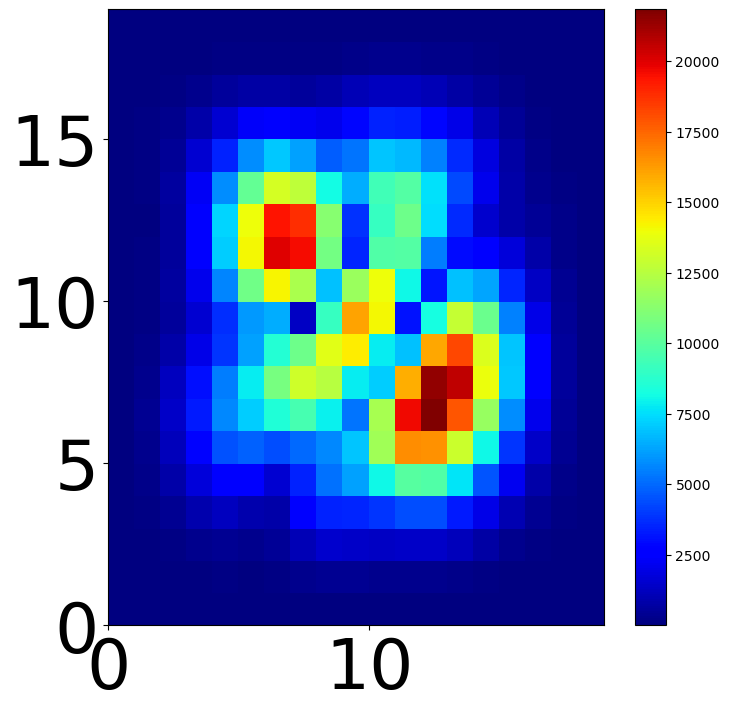

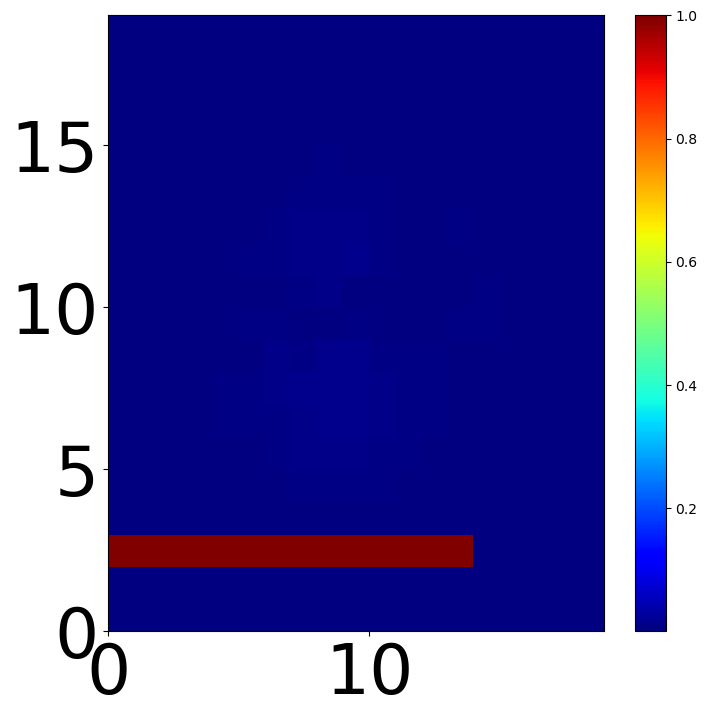

In [99]:
from numpy.linalg import pinv

%matplotlib inline
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
medium=medium1
print(medium.shape)


def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None, PSUEDO=False):
    plt.close()
    b=sensing@rho.T
    #print(rho)
    img=sensing_hat.T.conj()@b
    if PSUEDO:
        img=pinv((sensing_hat.T.conj()@sensing_hat))@img
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}


    output=img
    #print(output)

    output=np.abs(output)#/np.max(np.abs((output)))

    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    cbar=plt.colorbar(pcol, ax=ax)

    ax.tick_params(axis='both', **tick_params)
    plt.show()

#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

#output=np.abs(output)/np.max(np.abs((output)))

#output=output.reshape(20, 20)

ax=plt.gca()
#pcol_Used=ax.pcolor(output,cmap='jet')
medium_cols_changed=medium.copy()
rand_indices=np.random.choice(361, 361, replace=False)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])

medium_cols_changed=medium_cols_changed.T
#rand_indices=rand_indices[rand_indices not in range(19*2,19*3-5)]
change_list=[]
for i in range(361):
    if i not in range(19*2,19*3-6):
        change_list.append(i)
medium_cols_changed[change_list]=medium2.T[change_list]
medium_cols_changed=medium_cols_changed.T
rho=np.zeros((361))
#rho[99]=1
rho[19*2:19*3-5]=1
#rho[19*9+10]=1
#rho[-19-2]=1
#rho[-19*2+2]=1

KM_img_hat(rho, medium, medium_cols_changed,xpix=19, ypix=19,PSUEDO=True)

KM_img_hat(rho, medium, medium,xpix=19, ypix=19,PSUEDO=True)


In [72]:
medium_cols_changed=medium.copy()
rand_indices=np.random.choice(361, 361, replace=False)
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])


medium_cols_changed[rand_indices[:1]]=medium2[rand_indices[:1]]
print(rand_indices[:1], medium1.shape)
medium_cols_changed[1][:3], medium1[1][:3]

[214] (806, 361)


(array([-0.02224967-0.00915862j, -0.04116058-0.02824854j,
        -0.00084224-0.05033043j]),
 array([-0.02224967-0.00915862j, -0.04116058-0.02824854j,
        -0.00084224-0.05033043j]))

In [63]:
a=(sensing_hat.T.conj()@sensing_hat)
invert=pinv(a)
print(np.allclose(a@invert, np.eye(361)) )

a=np.array([[1,2],[3,4]])
invert=pinv(a)
np.allclose(a@invert, np.eye(2))

False


True

In [ ]:
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0')
medium1= np.array(mat73.loadmat(data_path+'/rtt_array.mat')['RM_realization_list'])
print(medium.shape)

medium=np.concatenate((medium1[:10]), axis=1)

#data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed1')
#medium2= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
#medium=np.concatenate((medium1.T, medium2.T), axis=0)

print(medium.shape)

medium=medium.T[:400]
medium=medium.T
print(medium.shape)
rho=np.zeros((400))
rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1

def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()
    b=sensing@rho.T
    #print(rho)
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}


    output=img
    print(output)

    output=np.abs(output)/np.max(np.abs((output)))

    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    cbar=plt.colorbar(pcol, ax=ax)

    ax.tick_params(axis='both', **tick_params)
    plt.show()

#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

#output=np.abs(output)/np.max(np.abs((output)))

#output=output.reshape(20, 20)

ax=plt.gca()
#pcol_Used=ax.pcolor(output,cmap='jet')
medium_cols_changed=medium.copy()

KM_img_hat(rho, medium, medium,xpix=20, ypix=20)


In [ ]:
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])

b=medium@rho.T
#print(rho)
img=medium.T.conj()@b

sum(img)

In [ ]:
medium=np.ar

In [ ]:
medium[0]

(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)


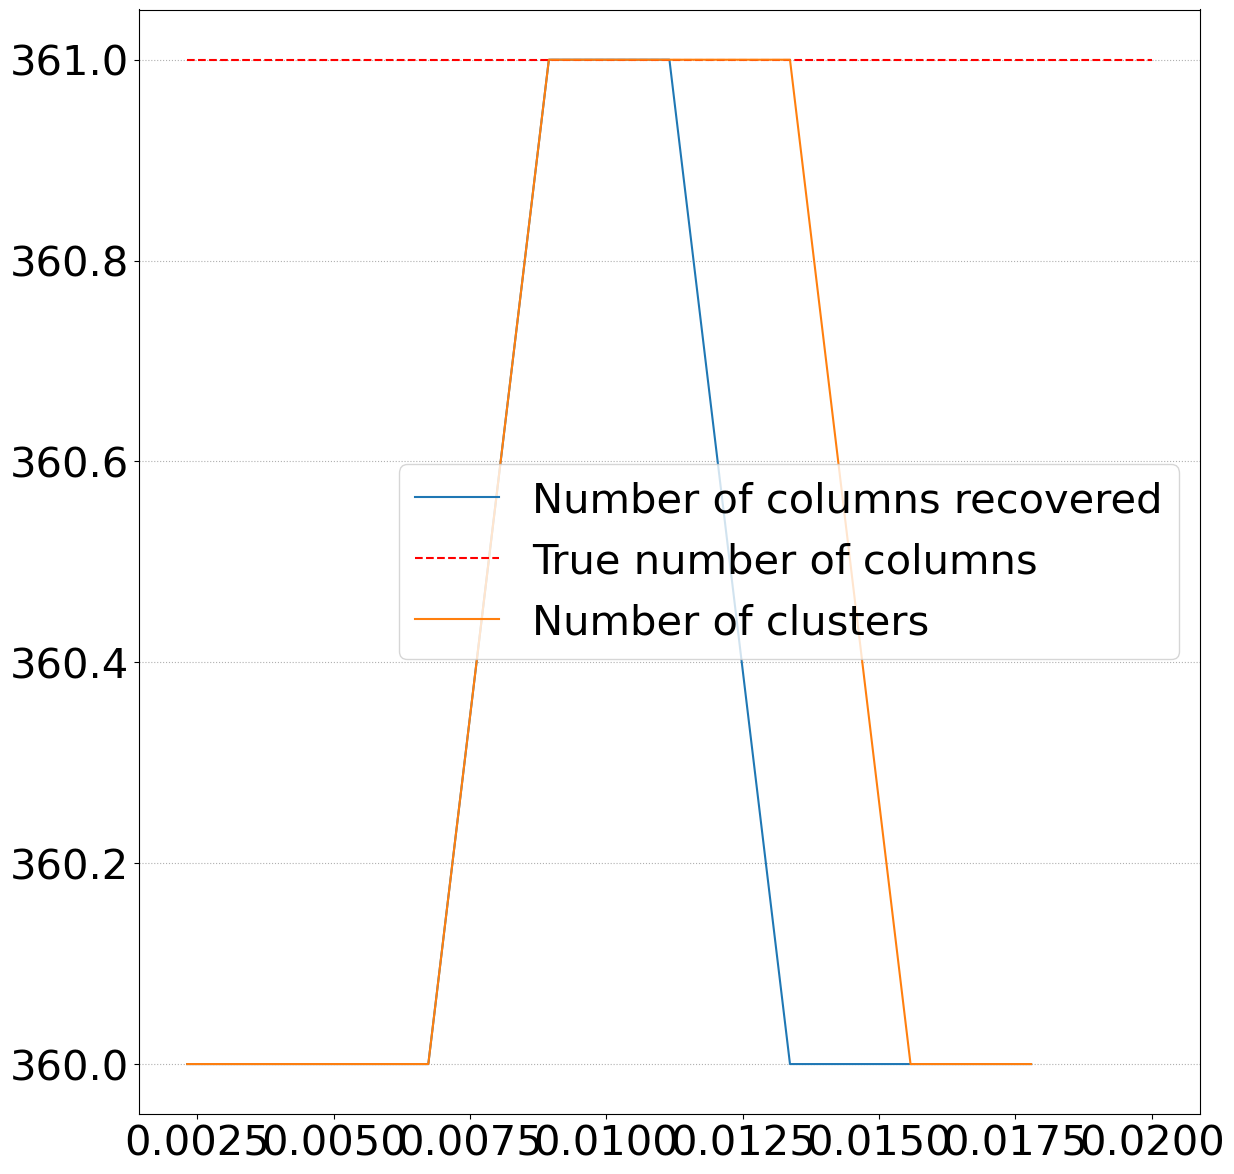

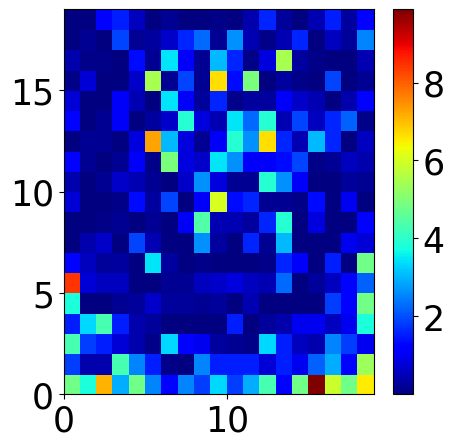

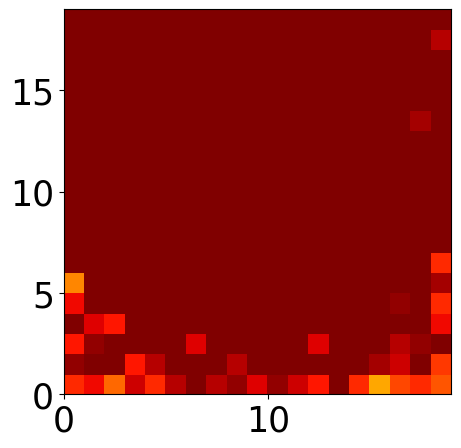

min number of recoveries 44, max number of recoveries 93


In [56]:
#NO Gelma KNET=10240
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/Nogelma_dictsize1024.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.0001,.02,10)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
perm=np.random.permutation(X.shape[0])
X=X[perm]
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers, Clustering='DBSCAN', Mhat=False, NUM_COLS=-1):

    if NUM_COLS>0:
        col_list=col_list[:NUM_COLS]
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        if Clustering=='DBSCAN':
            DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        else:
            print('OPTICS')
            DBSCAN_fit=OPTICS(min_samples=min_centers, max_eps=eps,metric='precomputed').fit(torch_inner)
            print('OPTICS ended lmao')
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    if Clustering=='DBSCAN':
                        cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    else:
                        cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])
    if Mhat:
        return medium_hat, num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
if True:
    for min_centers in [2]:
        perm=np.random.permutation(len(col_list))
        col_list=col_list[perm]
        medium_hat, num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(col_list, 3, Mhat=True, Clustering='DBSCAN', NUM_COLS=6000)
        num_recovered_list=num_recovered_list_CORES
        if len(eps_list)>0:
            plt.figure(figsize=(12,12))
            #plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
            plt.xticks(fontsize=30)
            plt.yticks(fontsize=30)# Add subticks to the y-axis
            plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
            plt.tight_layout()
            R=-1
            L=1
            plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            #plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
            #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
            plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
                #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
            plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
            #plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

            plt.legend(fontsize=30)
            plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
            plt.show()
            #plt.show()
            if False:
                plt.figure()
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)# Add subticks to the y-axis
                plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
                plt.tight_layout()
                #plt.plot(eps_list[L:R], Cluster_size_diff_list[L:R], label='Cluster size difference')
                plt.plot(eps_list[L:R], avg_cluster_size[L:R], label='Average cluster size')
                plt.plot(eps_list[L:R], smallest_cluster_used[L:R], label='Smallest cluster used')
                plt.plot(eps_list[L:R], next_largest_cluster[L:R], label='Next largest cluster')
                plt.legend()

                plt.show()
                plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
                plt.close()#Takes 7 minouts to run

index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0

for j in range(len(decoder_locats)):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=60)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [22]:
from sklearn.cluster import OPTICS
import numpy as np
X = np.array([[1, 2], [2, 5], [3, 6],
              [8, 7], [8, 8], [7, 3]])
dist=np.abs(np.inner(X,X.conj()))
clustering = OPTICS(min_samples=2, metric='precomputed').fit(dist)
clustering.labels_


array([0, 0, 0, 0, 0, 0])

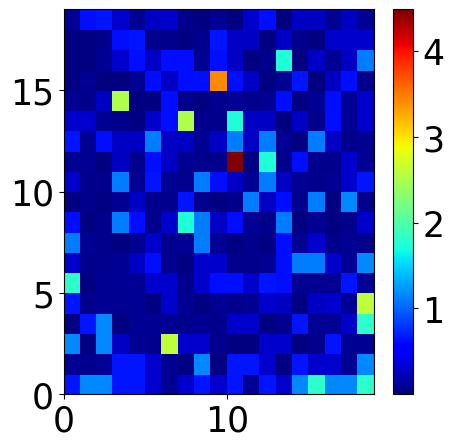

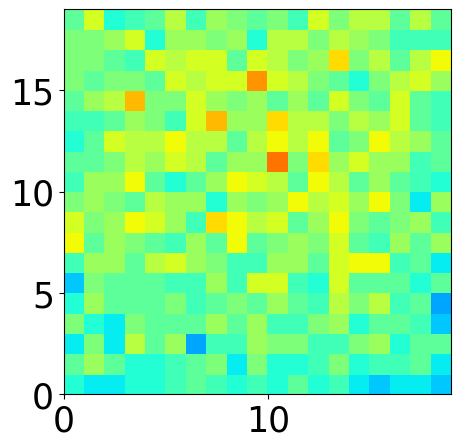

min number of recoveries 8, max number of recoveries 22


In [55]:

index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0

for j in range(5):
    col_list=get_cluster_data([decoder_locats[j]])
    total_num_cols+=len(col_list)
    num_times_recovered_list=[]
    inn_list_max_list=[]
    for i in range(361):
        G_i=medium.T[i]
        inn_list=abs(np.inner(G_i, col_list.conj()))
        inn_list_max_list.append(np.max(inn_list))
        #num_times_recovered=len(inn_list[inn_list>.99])
        num_times_recovered_list.append(num_times_recovered)
        num_times_recovered+=len(inn_list[inn_list>.99])
        indivual_recoveries[i]+=len(inn_list[inn_list>.99])
        


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=28)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')

In [49]:
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
max_inners=np.max(torch_inners, axis=0)
np.average(max_inners), len(max_inners[max_inners>.95])
col_list.shape

(1024, 806)

In [5]:
#NO Gelma KNET=10240
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/Nogelma_dictsize1024.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.0001,.02,10)

col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))

X=col_list
perm=np.random.permutation(X.shape[0])
X=X[perm]
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
min_centers=5
Clustering='DBSCAN'
NUM_COLS=(19**2)*5

def DBSCAN_inners_fig(col_list, min_centers, Clustering='DBSCAN', Mhat=False, NUM_COLS=-1):

    if NUM_COLS>0:
        col_list=col_list[:NUM_COLS]
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        if Clustering=='DBSCAN':
            DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        else:
            print('OPTICS')
            DBSCAN_fit=OPTICS(min_samples=min_centers, max_eps=eps,metric='precomputed').fit(torch_inner)
            print('OPTICS ended lmao')



DBSCAN_inners_fig(col_list, 3, Mhat=True, Clustering='OPTIC', NUM_COLS=6000)
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)




# Run the fit
clust.fit(X)











labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)
OPTICS
OPTICS ended lmao
OPTICS
OPTICS ended lmao
OPTICS


KeyboardInterrupt: 

In [ ]:
#NO Gelma KNET=10240
NUM_COLS_USED=5000
cwd=os.getcwd()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')



medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=20000

decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
timescampstrs = H.read_and_concatenate('/home/achristie/RM_imaging/Data/Nogelma_dictsize1024.csv')

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}

pixels='Gaussian_abs'
T_hold=.99
def oreinted_mean(z):
    z_inners=np.inner(z,z.conj())
    ret_z=[]
    for  i in range(z.shape[0]):
        if z_inners[0,i]>0:
            ret_z.append(z[i])
        else:
            ret_z.append(-z[i])
    return np.mean(np.array(ret_z), axis=0)
decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Dict_size=1024*2

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        Complex_eye=torch.cat((torch.eye(int(Dict_size/2)), torch.zeros((int(Dict_size/2),int(Dict_size/2)))), dim=1)
        decoder=M.norm_linear_complex(Dict_size, int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(curr_decoder))

        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)

eps_linspace=np.linspace(.00005,.5,4)
col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))


perm=np.random.permutation(col_list.shape[0])
#col_list=col_list[perm]

X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
columns=X
def DBSCAN_inners_fig(col_list, min_centers, Clustering='DBSCAN', Mhat=False):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    print(col_list.shape, torch_inner.shape)
    num_recovered_list=[]
    num_recovered_list_97=[]
    Cluster_size_diff_list=[]
    avg_cluster_size=[]
    smallest_cluster_used=[]
    next_largest_cluster=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]


    for eps in eps_linspace:
        if Clustering=='DBSCAN':
            DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        else:
            print('OPTICS')
            DBSCAN_fit=OPTICS(min_samples=min_centers, max_eps=eps,metric='precomputed').fit(torch_inner)
            print('OPTICS ended lmao')
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
            #Cluster_size_diff_list.append(0)
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size and  Clustering=='DBSCAN':
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                else:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i]
                        
                ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)
            try:
                Cluster_size_diff_list.append(sorted_cluster_sizes[-361]-sorted_cluster_sizes[-362])
                next_largest_cluster.append(sorted_cluster_sizes[-362])
            except:
                Cluster_size_diff_list.append(0)
                next_largest_cluster.append(sorted_cluster_sizes[0])



            
            avg_cluster_size.append(np.mean(cluster_sizes))
            try:
                smallest_cluster_used.append(sorted_cluster_sizes[-361])
            except:
                smallest_cluster_used.append(sorted_cluster_sizes[0])

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])
    if Mhat:
        return medium_hat, num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES, Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list
if True:
    for min_centers in [2]:
        training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
        b=F.normalize(training_data.b, dim=-1)
        b=H.cat2complex(b).cpu().detach().numpy()
        num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,Cluster_size_diff_list,avg_cluster_size, smallest_cluster_used, next_largest_cluster, eps_list=DBSCAN_inners_fig(b, min_centers, Mhat=False, Clustering='b')
        num_recovered_list=num_recovered_list_CORES
if len(eps_list)>0:
    L=0
    R=len(eps_list)
    plt.figure(figsize=(12,12))
    plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='true number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)# Add subticks to the y-axis
    plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
    plt.tight_layout()
    
    plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
    plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')
    #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
    #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
        #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
    plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')
    plt.plot(eps_list[L:R], num_really_bad[L:R], label='Number of columns recovered with less than .95')

    plt.legend(fontsize=30)
    plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}_NOGELMA_KNET1024.pdf')
    plt.show()
        



index_of_shittiest=[]
num_times_recovered=0
indivual_recoveries=[0]*361
total_num_cols=0

col_list=col_list[:NUM_COLS_USED]
total_num_cols+=len(col_list[:NUM_COLS_USED])
num_times_recovered_list=[]
inn_list_max_list=[]
for i in range(361):
    G_i=medium.T[i]
    inn_list=abs(np.inner(G_i, col_list.conj()))
    inn_list_max_list.append(np.max(inn_list))
    #num_times_recovered=len(inn_list[inn_list>.99])
    num_times_recovered_list.append(num_times_recovered)
    num_times_recovered+=len(inn_list[inn_list>.99])
    indivual_recoveries[i]+=len(inn_list[inn_list>.99])
    


Pop_mean=num_times_recovered/(total_num_cols)
#indivual_recoveries_missed=np.array([50-i for i in indivual_recoveries])
indivual_recoveries=np.array(indivual_recoveries)
p_hat=Pop_mean
expected_recoveries=np.array([Pop_mean*(total_num_cols/361)])
TS_list=[(indivual_recoveries[i]-p_hat*(total_num_cols/361))**2/(p_hat*(total_num_cols/361)) for i in range(361)]
sum(TS_list), chi2.cdf(sum(TS_list), 360)





rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=np.array(TS_list)
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True)




rho=np.array(TS_list)

rho_hat=np.zeros((2, 361))

rho_hat[0, :]=indivual_recoveries
rho=torch.tensor(rho)
rho_hat=torch.tensor(rho_hat)
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
#rho[210]=1

H.plot_2_imgs(rho, rho_hat,ind=0, figsize=5, scaling=None, xpix=19, ypix=19, font_size=25, Single=True, Lclim=0, Hclim=13)
print(f'min number of recoveries {min(indivual_recoveries)}, max number of recoveries {max(indivual_recoveries)}')




(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (20000, 361), B: (20000, 806)
shape of the union without removin: (25600, 806), number for Expceriments: 70
(806,)
Medium: (806, 361), Rho: (20000, 361), B: (20000, 806)
(20000, 806) (20000, 20000)
OPTICS


/home/achristie/anaconda3/envs/Workstation1/lib/python3.8/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


OPTICS ended lmao
OPTICS


/home/achristie/anaconda3/envs/Workstation1/lib/python3.8/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


OPTICS ended lmao
OPTICS


Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)


(5000, 806)

In [12]:
sum(abs(b[0])**2)

1.000000038365215

In [30]:
ata_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)

(806, 361)
(361, 361)
coherence of data:  0.763143828697641


In [31]:
training_data=H.data_rho_loaded(data_path+'/train',5000/80000,pixels=pixels, normalize=False)
b=F.normalize(training_data.b, dim=-1)
b=H.cat2complex(b).cpu().detach().numpy()
medium=b
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)

Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
(5000, 806)
(806, 806)
coherence of data:  6.5951166


In [32]:
torch_inner=np.abs(1.0-(np.abs(np.inner(b,b.conj()))))


In [38]:
np.min(torch_inner)

0.0